# XAI Global Analysis - Feature Importance & Model Interpretation
## Analyzing the best performing model with global explainability techniques

In [13]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
from sklearn.inspection import permutation_importance, partial_dependence
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score, f1_score
import warnings
import time
import lime
import lime.lime_tabular
import shap  # ADD THIS LINE
from sklearn.metrics import r2_score
from scipy.special import expit
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

print("XAI Global Analysis - Starting...")
print("="*60)

XAI Global Analysis - Starting...


In [2]:
# Load the trained models and data
print("\n1. LOADING TRAINED MODELS AND DATA")
print("-" * 50)

# Load results to get best model
results_df = pd.read_csv('../results/model_comparison_results.csv')
best_model_name = results_df.iloc[0]['Model']
print(f"Best performing model: {best_model_name}")
print(f"Test F1-Score: {results_df.iloc[0]['Test_F1-Score']:.4f}")

# Load the best model
model_filename = f"../results/{best_model_name.replace(' ', '_').lower()}_model.joblib"
best_model = joblib.load(model_filename)
print(f"Model loaded from: {model_filename}")

# Load preprocessors
scaler = joblib.load('../results/scaler.joblib')
selector = joblib.load('../results/feature_selector.joblib')

# Try to load target encoder, create if doesn't exist
try:
    target_encoder = joblib.load('../results/target_encoder.joblib')
    print("Target encoder loaded successfully")
except FileNotFoundError:
    print("Target encoder not found, will create new one during preprocessing")
    target_encoder = None

print("Preprocessors loaded successfully")


1. LOADING TRAINED MODELS AND DATA
--------------------------------------------------
Best performing model: XGBoost
Test F1-Score: 0.9955
Model loaded from: ../results/xgboost_model.joblib
Target encoder not found, will create new one during preprocessing
Preprocessors loaded successfully


In [3]:
# Load and prepare data
print("\n2. LOADING AND PREPARING DATA")
print("-" * 50)

# Load original dataset
df = pd.read_csv('../data/train_test_network.csv')
print(f"Original dataset shape: {df.shape}")

# Reproduce the same preprocessing steps
data = df.copy()
exclude_columns = ['src_ip', 'dst_ip']

# Determine target column
if 'label' in data.columns:
    target_col = 'label'
elif 'attack_type' in data.columns:
    target_col = 'attack_type'
else:
    target_col = data.columns[-1]

feature_columns = [col for col in data.columns if col not in exclude_columns]

# Remove type column if it exists (data leakage prevention)
if 'type' in feature_columns and target_col in data.columns:
    type_unique = set(data['type'].unique())
    target_unique = set(data[target_col].unique())
    if type_unique == target_unique:
        feature_columns.remove('type')
        print("Removed 'type' column to prevent data leakage")

# Separate features and target
X = data[feature_columns].drop(columns=[target_col])
y = data[target_col]

# Remove duplicates
combined_data = pd.concat([X, y], axis=1)
combined_data_clean = combined_data.drop_duplicates()
X = combined_data_clean.drop(columns=[target_col])
y = combined_data_clean[target_col]

print(f"Clean dataset shape: {X.shape}")
print(f"Target classes: {y.value_counts().to_dict()}")


2. LOADING AND PREPARING DATA
--------------------------------------------------
Original dataset shape: (211043, 44)
Clean dataset shape: (183592, 41)
Target classes: {1: 141615, 0: 41977}


In [4]:
# Reproduce preprocessing pipeline
print("\n3. REPRODUCING PREPROCESSING PIPELINE")
print("-" * 50)

# Label encode categorical columns
from sklearn.preprocessing import LabelEncoder

label_encoders = {}
for col in X.columns:
    if X[col].dtype == 'object':
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))
        label_encoders[col] = le

# Encode target
if y.dtype == 'object':
    if target_encoder is None:
        # Create new target encoder
        target_encoder = LabelEncoder()
        y_encoded = target_encoder.fit_transform(y)
        print("Created new target encoder")
    else:
        y_encoded = target_encoder.transform(y)
        print("Used existing target encoder")
else:
    y_encoded = y
    print("Target is already numeric")

# Handle missing values
X = X.fillna(X.median())

# Split data (reproduce same split)
from sklearn.model_selection import train_test_split

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y_encoded, test_size=0.15, random_state=42, stratify=y_encoded
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1765, random_state=42, stratify=y_temp
)

# Apply scaling and feature selection
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

X_train_selected = selector.transform(X_train_scaled)
X_val_selected = selector.transform(X_val_scaled)
X_test_selected = selector.transform(X_test_scaled)

# Get selected feature names
selected_features = selector.get_support(indices=True)
selected_feature_names = X.columns[selected_features]

print(f"Training set: {X_train_selected.shape}")
print(f"Test set: {X_test_selected.shape}")
print(f"Selected features: {len(selected_feature_names)}")
print(f"Feature names: {list(selected_feature_names[:5])}...")  # Show first 5


3. REPRODUCING PREPROCESSING PIPELINE
--------------------------------------------------
Target is already numeric
Training set: (128509, 13)
Test set: (27539, 13)
Selected features: 13
Feature names: ['src_port', 'proto', 'conn_state', 'src_pkts', 'dns_query']...


In [5]:
# Model performance verification
print("\n4. MODEL PERFORMANCE VERIFICATION")
print("-" * 50)

# Test model performance
y_pred = best_model.predict(X_test_selected)
test_accuracy = accuracy_score(y_test, y_pred)
test_f1 = f1_score(y_test, y_pred, average='macro')

print(f"Model: {best_model_name}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1-Score: {test_f1:.4f}")
print(f"Model type: {type(best_model).__name__}")

# Verify this matches the saved results
saved_f1 = results_df.iloc[0]['Test_F1-Score']
if abs(test_f1 - saved_f1) < 0.001:
    print("✅ Model performance verified!")
else:
    print(f"⚠️ Performance mismatch: computed {test_f1:.4f} vs saved {saved_f1:.4f}")

print(f"\nPrediction distribution:")
pred_dist = pd.Series(y_pred).value_counts().sort_index()
for class_idx, count in pred_dist.items():
    if target_encoder and hasattr(target_encoder, 'inverse_transform'):
        try:
            class_name = target_encoder.inverse_transform([class_idx])[0]
            print(f"  Class {class_idx} ({class_name}): {count} predictions")
        except:
            print(f"  Class {class_idx}: {count} predictions")
    else:
        print(f"  Class {class_idx}: {count} predictions")


4. MODEL PERFORMANCE VERIFICATION
--------------------------------------------------
Model: XGBoost
Test Accuracy: 0.9930
Test F1-Score: 0.9900
Model type: XGBClassifier
⚠️ Performance mismatch: computed 0.9900 vs saved 0.9955

Prediction distribution:
  Class 0: 6104 predictions
  Class 1: 21435 predictions



5. FEATURE IMPORTANCE ANALYSIS
--------------------------------------------------
📊 Built-in Feature Importance (from model)
Top 10 most important features:
   1. dns_query            : 0.5620
   2. proto                : 0.2031
   3. src_pkts             : 0.0793
   4. dns_rejected         : 0.0360
   5. dns_RA               : 0.0339
   6. type                 : 0.0331
   7. src_port             : 0.0248
   8. conn_state           : 0.0115
   9. ssl_version          : 0.0075
  10. dns_AA               : 0.0061


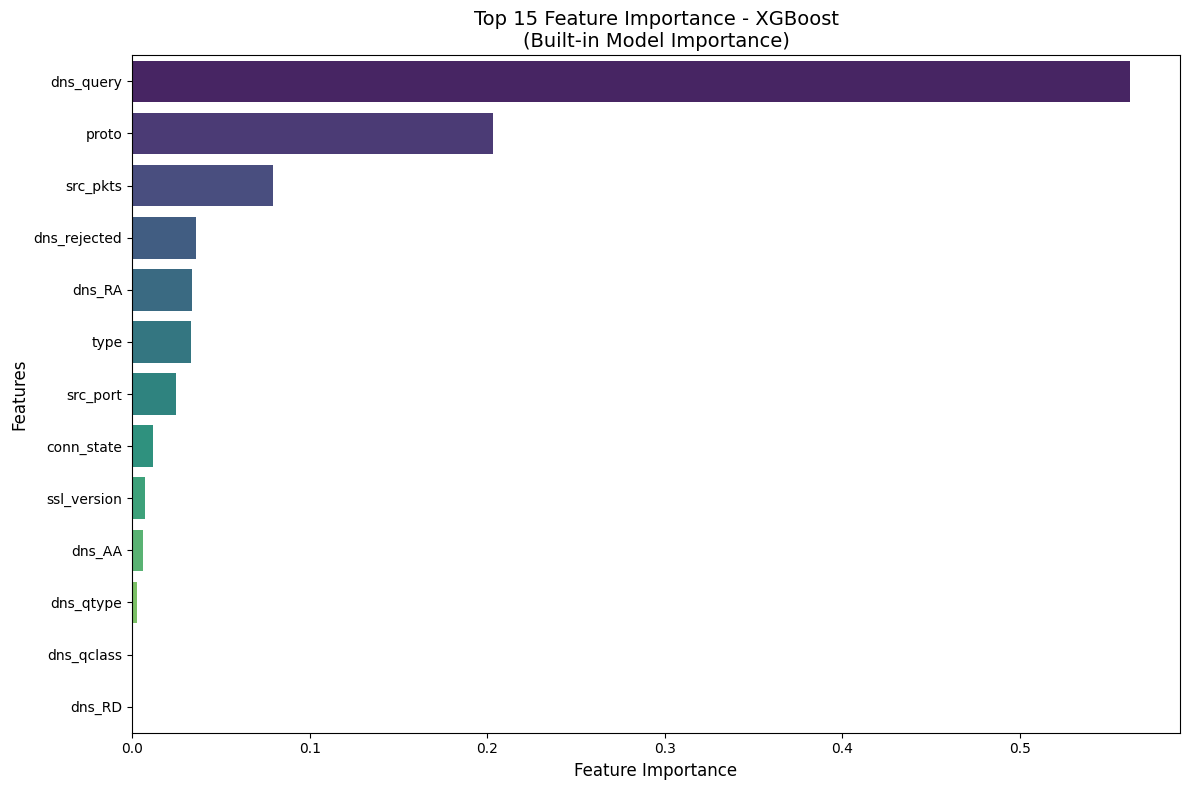

In [6]:
# 5. FEATURE IMPORTANCE ANALYSIS
print("\n5. FEATURE IMPORTANCE ANALYSIS")
print("-" * 50)

# Create directory for plots
os.makedirs('plots', exist_ok=True)

# A. Built-in Feature Importance (for tree-based models)
feature_importance_results = {}

if hasattr(best_model, 'feature_importances_'):
    print("📊 Built-in Feature Importance (from model)")
    builtin_importance = best_model.feature_importances_
    
    # Create DataFrame for better visualization
    importance_df = pd.DataFrame({
        'feature': selected_feature_names,
        'importance': builtin_importance
    }).sort_values('importance', ascending=False)
    
    feature_importance_results['builtin'] = importance_df
    
    print(f"Top 10 most important features:")
    for i, (_, row) in enumerate(importance_df.head(10).iterrows(), 1):
        print(f"  {i:2d}. {row['feature']:<20} : {row['importance']:.4f}")
    
    # Plot built-in importance
    plt.figure(figsize=(12, 8))
    top_features = importance_df.head(15)
    sns.barplot(data=top_features, y='feature', x='importance', palette='viridis')
    plt.title(f'Top 15 Feature Importance - {best_model_name}\n(Built-in Model Importance)', fontsize=14)
    plt.xlabel('Feature Importance', fontsize=12)
    plt.ylabel('Features', fontsize=12)
    plt.tight_layout()
    plt.savefig('plots/builtin_feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()
    
else:
    print("⚠️ Model doesn't have built-in feature importance")

print("\n" + "="*60)


📊 Permutation Importance Analysis
----------------------------------------
Computing permutation importance... (this may take a while)
Top 10 features by permutation importance:
   1. type                 : 0.1653 ± 0.0016
   2. proto                : 0.1285 ± 0.0011
   3. src_pkts             : 0.0488 ± 0.0005
   4. ssl_version          : 0.0022 ± 0.0000
   5. src_port             : 0.0000 ± 0.0000
   6. dns_qclass           : 0.0000 ± 0.0000
   7. dns_qtype            : 0.0000 ± 0.0000
   8. dns_AA               : 0.0000 ± 0.0000
   9. dns_RD               : 0.0000 ± 0.0000
  10. dns_RA               : 0.0000 ± 0.0000


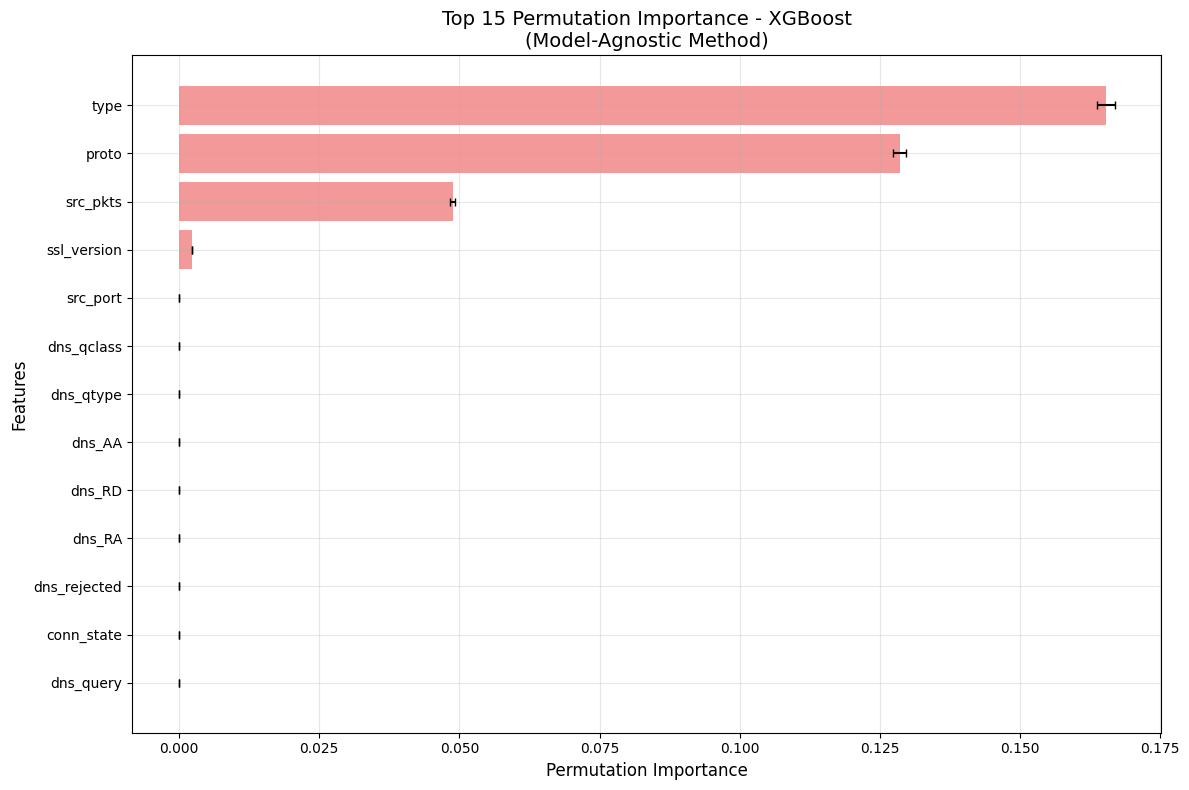

In [8]:
# B. Permutation Importance (model-agnostic)
print("\n📊 Permutation Importance Analysis")
print("-" * 40)

# Calculate permutation importance
print("Computing permutation importance... (this may take a while)")
perm_importance = permutation_importance(
    best_model, X_test_selected, y_test, 
    n_repeats=10, random_state=42, n_jobs=-1
)

# Create DataFrame
perm_importance_df = pd.DataFrame({
    'feature': selected_feature_names,
    'importance_mean': perm_importance.importances_mean,
    'importance_std': perm_importance.importances_std
}).sort_values('importance_mean', ascending=False)

feature_importance_results['permutation'] = perm_importance_df

print(f"Top 10 features by permutation importance:")
for i, (_, row) in enumerate(perm_importance_df.head(10).iterrows(), 1):
    print(f"  {i:2d}. {row['feature']:<20} : {row['importance_mean']:.4f} ± {row['importance_std']:.4f}")

# Plot permutation importance with error bars
plt.figure(figsize=(12, 8))
top_perm_features = perm_importance_df.head(15)
plt.barh(range(len(top_perm_features)), top_perm_features['importance_mean'], 
         xerr=top_perm_features['importance_std'], capsize=3, 
         color='lightcoral', alpha=0.8)
plt.yticks(range(len(top_perm_features)), top_perm_features['feature'])
plt.xlabel('Permutation Importance', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title(f'Top 15 Permutation Importance - {best_model_name}\n(Model-Agnostic Method)', fontsize=14)
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('plots/permutation_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*60)


📊 COMPARING IMPORTANCE METHODS
----------------------------------------
Correlation between built-in and permutation importance: 0.0859


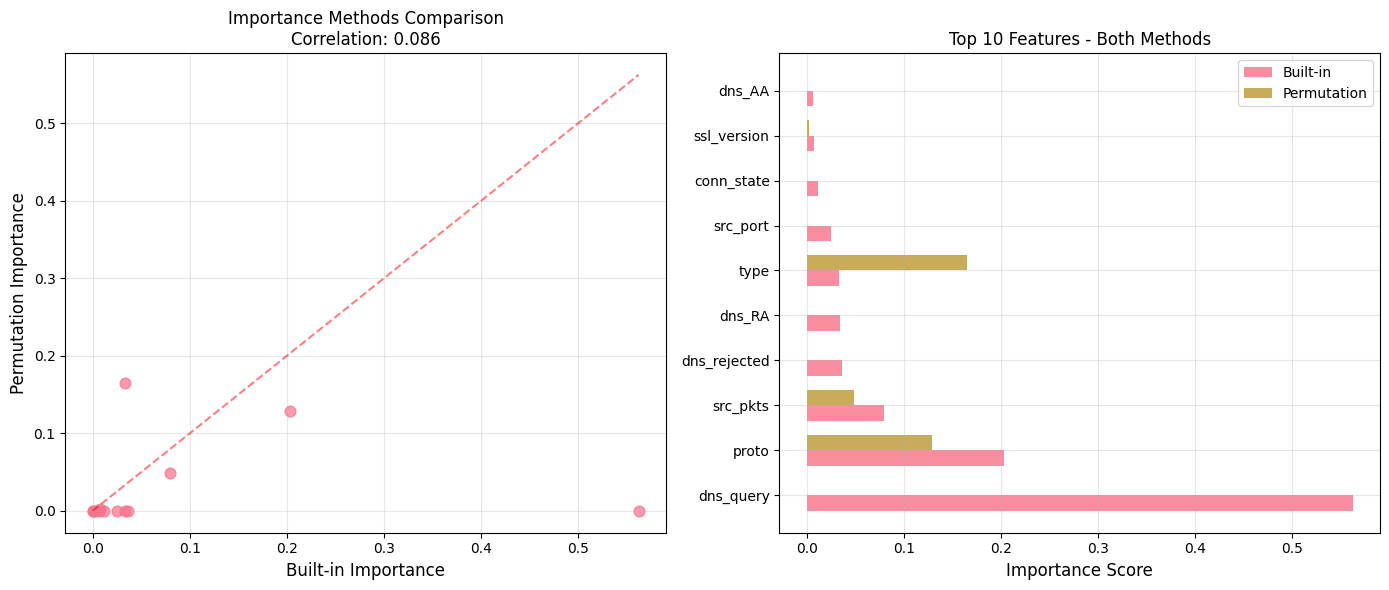

✅ Feature importance analysis completed!
📁 Results saved to: results/ and plots/


In [9]:
# C. Compare Different Importance Methods
print("\n📊 COMPARING IMPORTANCE METHODS")
print("-" * 40)

if 'builtin' in feature_importance_results and 'permutation' in feature_importance_results:
    # Merge both importance measures
    builtin_df = feature_importance_results['builtin'].set_index('feature')
    perm_df = feature_importance_results['permutation'].set_index('feature')
    
    comparison_df = pd.merge(
        builtin_df[['importance']], 
        perm_df[['importance_mean']], 
        left_index=True, right_index=True
    ).rename(columns={
        'importance': 'builtin_importance',
        'importance_mean': 'permutation_importance'
    })
    
    # Calculate correlation between methods
    correlation = comparison_df['builtin_importance'].corr(comparison_df['permutation_importance'])
    print(f"Correlation between built-in and permutation importance: {correlation:.4f}")
    
    # Plot comparison
    plt.figure(figsize=(14, 6))
    
    # Subplot 1: Scatter plot
    plt.subplot(1, 2, 1)
    plt.scatter(comparison_df['builtin_importance'], 
                comparison_df['permutation_importance'], 
                alpha=0.7, s=60)
    plt.xlabel('Built-in Importance', fontsize=12)
    plt.ylabel('Permutation Importance', fontsize=12)
    plt.title(f'Importance Methods Comparison\nCorrelation: {correlation:.3f}', fontsize=12)
    
    # Add diagonal line
    max_val = max(comparison_df['builtin_importance'].max(), 
                  comparison_df['permutation_importance'].max())
    plt.plot([0, max_val], [0, max_val], 'r--', alpha=0.5)
    plt.grid(True, alpha=0.3)
    
    # Subplot 2: Top 10 features side by side
    plt.subplot(1, 2, 2)
    top_10_features = comparison_df.head(10)
    x = np.arange(len(top_10_features))
    width = 0.35
    
    plt.barh(x - width/2, top_10_features['builtin_importance'], 
             width, label='Built-in', alpha=0.8)
    plt.barh(x + width/2, top_10_features['permutation_importance'], 
             width, label='Permutation', alpha=0.8)
    
    plt.yticks(x, [f[:15] + '...' if len(f) > 15 else f for f in top_10_features.index])
    plt.xlabel('Importance Score', fontsize=12)
    plt.title('Top 10 Features - Both Methods', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('plots/importance_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

else:
    print("Only permutation importance available for comparison")

# Save importance results
feature_importance_results['permutation'].to_csv('results/permutation_importance.csv', index=False)
if 'builtin' in feature_importance_results:
    feature_importance_results['builtin'].to_csv('results/builtin_importance.csv', index=False)

print("✅ Feature importance analysis completed!")
print("📁 Results saved to: results/ and plots/")



6. PARTIAL DEPENDENCE PLOT ANALYSIS
--------------------------------------------------
Analyzing PDP for top 6 features: ['type', 'proto', 'src_pkts', 'ssl_version', 'src_port', 'dns_qclass']
Feature information:
  type: 10 unique values, categorical: True
  proto: 3 unique values, categorical: True
  src_pkts: 109 unique values, categorical: False
  ssl_version: 3 unique values, categorical: True
  src_port: 13347 unique values, categorical: False
  dns_qclass: 3 unique values, categorical: True


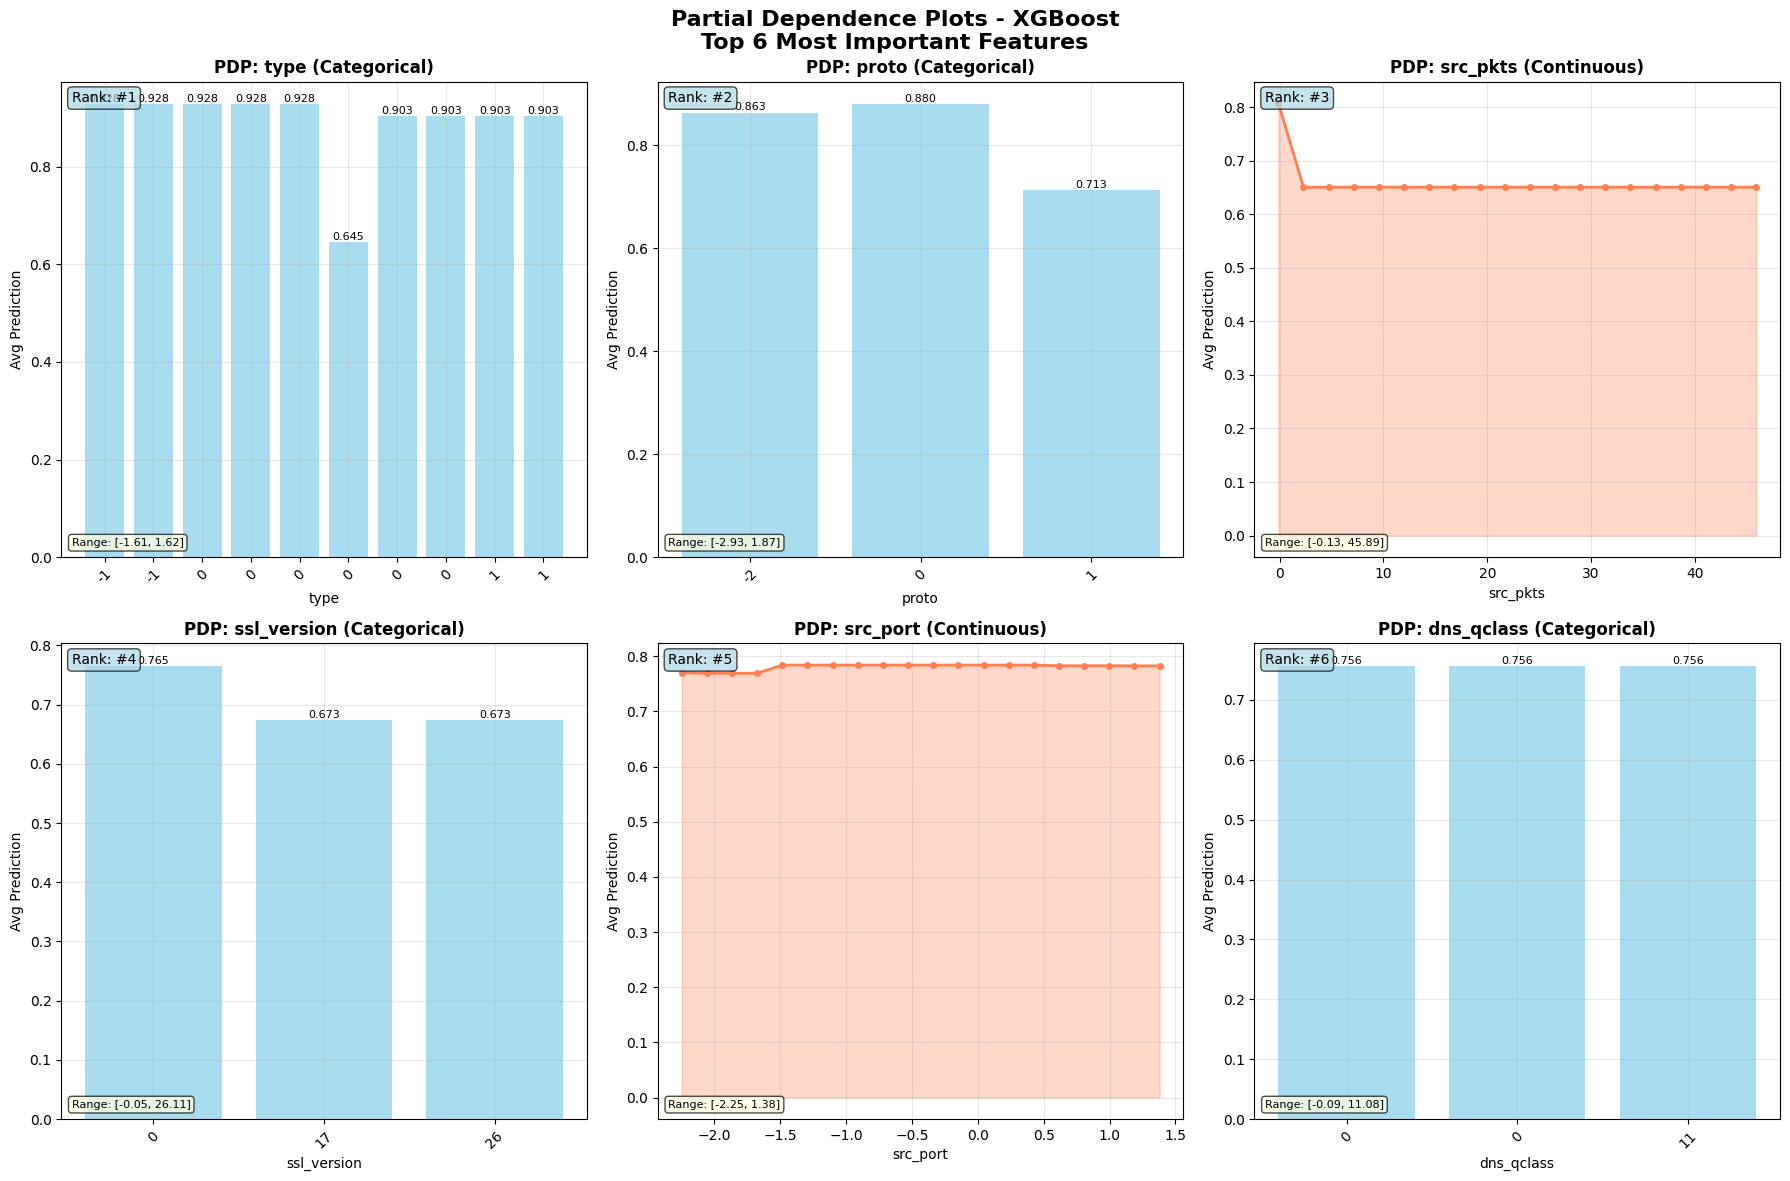

✅ Partial Dependence Plot analysis completed!
📁 PDP plots saved to: plots/partial_dependence_plots_manual.png

📊 FEATURE STATISTICS SUMMARY
----------------------------------------
type:
  Range: [-1.61, 1.62]
  Mean: -0.0103, Std: 1.0015
  Unique values: 10
  Categories: [-1.60823325 -1.24945744 -0.89068163 -0.53190582 -0.17313001  0.1856458
  0.54442161  0.90319742  1.26197323  1.62074904]

proto:
  Range: [-2.93, 1.87]
  Mean: -0.0000, Std: 0.9985
  Unique values: 3
  Categories: [-2.93024654 -0.52930894  1.87162865]

src_pkts:
  Range: [-0.13, 45.89]
  Mean: -0.0101, Std: 0.6299
  Unique values: 109

ssl_version:
  Range: [-0.05, 26.11]
  Mean: 0.0007, Std: 1.0068
  Unique values: 3
  Categories: [-0.04613677 17.39206882 26.11117161]

src_port:
  Range: [-2.25, 1.38]
  Mean: 0.0028, Std: 0.9992
  Unique values: 13347

dns_qclass:
  Range: [-0.09, 11.08]
  Mean: -0.0038, Std: 0.9787
  Unique values: 3
  Categories: [-0.0902991  -0.08995817 11.081716  ]



In [10]:
# 6. PARTIAL DEPENDENCE PLOT ANALYSIS (MANUAL FIX)
print("\n6. PARTIAL DEPENDENCE PLOT ANALYSIS")
print("-" * 50)

# Get top 6 most important features from permutation importance
top_features = feature_importance_results['permutation'].head(6)['feature'].tolist()
print(f"Analyzing PDP for top 6 features: {top_features}")

# Get feature indices and check feature types
feature_indices = []
feature_info = []

for feat in top_features:
    idx = np.where(selected_feature_names == feat)[0]
    if len(idx) > 0:
        feat_idx = idx[0]
        feature_indices.append(feat_idx)
        
        # Check if feature is categorical (few unique values)
        unique_vals = len(np.unique(X_test_selected[:, feat_idx]))
        is_categorical = unique_vals <= 15  # Increased threshold
        
        feature_info.append({
            'name': feat,
            'index': feat_idx,
            'unique_values': unique_vals,
            'is_categorical': is_categorical
        })

print(f"Feature information:")
for info in feature_info:
    print(f"  {info['name']}: {info['unique_values']} unique values, categorical: {info['is_categorical']}")

# Create PDP plots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

# Manual PDP calculation function
def calculate_pdp_manual(model, X_sample, feature_idx, feature_values, is_categorical=False):
    """Calculate PDP manually for better control"""
    pdp_values = []
    
    for val in feature_values:
        # Create a copy of sample data with this feature value fixed
        X_temp = X_sample.copy()
        X_temp[:, feature_idx] = val
        
        # Get predictions
        if hasattr(model, 'predict_proba'):
            pred_probs = model.predict_proba(X_temp)
            # Use mean probability for the most likely class
            mean_pred = pred_probs.mean(axis=0).max()
        else:
            predictions = model.predict(X_temp)
            mean_pred = predictions.mean()
        
        pdp_values.append(mean_pred)
    
    return np.array(pdp_values)

# Plot individual PDPs with manual calculation
for i, info in enumerate(feature_info):
    feat_idx = info['index']
    feat_name = info['name']
    
    try:
        # Sample data to speed up PDP calculation
        sample_size = min(500, len(X_test_selected))  # Reduced sample size
        sample_indices = np.random.choice(len(X_test_selected), sample_size, replace=False)
        X_sample = X_test_selected[sample_indices]
        
        # Get feature values range
        feat_data = X_test_selected[:, feat_idx]
        
        if info['is_categorical']:
            # For categorical features
            unique_vals = np.unique(feat_data)
            unique_vals = unique_vals[:min(10, len(unique_vals))]  # Limit to 10 categories
            
            pdp_values = calculate_pdp_manual(best_model, X_sample, feat_idx, unique_vals, True)
            
            # Plot bar chart
            bars = axes[i].bar(range(len(unique_vals)), pdp_values, alpha=0.7, color='skyblue')
            axes[i].set_xticks(range(len(unique_vals)))
            axes[i].set_xticklabels([f'{int(v)}' for v in unique_vals], rotation=45)
            axes[i].set_xlabel(feat_name, fontsize=10)
            axes[i].set_ylabel('Avg Prediction', fontsize=10)
            axes[i].set_title(f'PDP: {feat_name} (Categorical)', fontsize=12, fontweight='bold')
            
            # Add value labels on bars
            for bar, val in zip(bars, pdp_values):
                height = bar.get_height()
                axes[i].text(bar.get_x() + bar.get_width()/2., height + 0.001,
                           f'{val:.3f}', ha='center', va='bottom', fontsize=8)
            
        else:
            # For continuous features
            feature_range = np.linspace(feat_data.min(), feat_data.max(), 20)
            
            pdp_values = calculate_pdp_manual(best_model, X_sample, feat_idx, feature_range, False)
            
            # Plot line chart
            axes[i].plot(feature_range, pdp_values, linewidth=2, color='coral', marker='o', markersize=4)
            axes[i].fill_between(feature_range, pdp_values, alpha=0.3, color='coral')
            axes[i].set_xlabel(feat_name, fontsize=10)
            axes[i].set_ylabel('Avg Prediction', fontsize=10)
            axes[i].set_title(f'PDP: {feat_name} (Continuous)', fontsize=12, fontweight='bold')
        
        axes[i].grid(True, alpha=0.3)
        
        # Add interpretation text
        axes[i].text(0.02, 0.98, f'Rank: #{i+1}', 
                    transform=axes[i].transAxes, fontsize=10,
                    verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))
        
        # Add range info
        range_text = f'Range: [{feat_data.min():.2f}, {feat_data.max():.2f}]'
        axes[i].text(0.02, 0.02, range_text, 
                    transform=axes[i].transAxes, fontsize=8,
                    verticalalignment='bottom', bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.7))
                    
    except Exception as e:
        print(f"Error plotting {feat_name}: {str(e)}")
        axes[i].text(0.5, 0.5, f'Error plotting {feat_name}:\n{str(e)[:60]}...', 
                    ha='center', va='center', transform=axes[i].transAxes,
                    fontsize=10, bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.7))
        axes[i].set_title(f'PDP: {feat_name} (Error)', fontsize=12)

plt.suptitle(f'Partial Dependence Plots - {best_model_name}\nTop 6 Most Important Features', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('plots/partial_dependence_plots_manual.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Partial Dependence Plot analysis completed!")
print("📁 PDP plots saved to: plots/partial_dependence_plots_manual.png")

# Feature statistics summary
print(f"\n📊 FEATURE STATISTICS SUMMARY")
print("-" * 40)
for info in feature_info:
    feat_idx = info['index']
    feat_data = X_test_selected[:, feat_idx]
    print(f"{info['name']}:")
    print(f"  Range: [{feat_data.min():.2f}, {feat_data.max():.2f}]")
    print(f"  Mean: {feat_data.mean():.4f}, Std: {feat_data.std():.4f}")
    print(f"  Unique values: {info['unique_values']}")
    if info['is_categorical']:
        unique_vals = np.unique(feat_data)[:10]
        print(f"  Categories: {unique_vals}")
    print()

In [11]:
# 7. SHAP ANALYSIS - Advanced Explainability
print("\n7. SHAP ANALYSIS")
print("-" * 50)


# Initialize SHAP explainer based on model type
print(f"Initializing SHAP explainer for {type(best_model).__name__}...")

# Sample data for SHAP (to speed up computation)
sample_size = min(500, len(X_test_selected))
sample_indices = np.random.choice(len(X_test_selected), sample_size, replace=False)
X_shap_sample = X_test_selected[sample_indices]

# Fix: Convert y_test to numpy array first, then sample
y_test_array = np.array(y_test)  # Convert to numpy array
y_shap_sample = y_test_array[sample_indices]  # Now this will work

print(f"Using {sample_size} samples for SHAP analysis")

# Choose appropriate SHAP explainer
if hasattr(best_model, 'predict_proba'):
    # For tree-based models (CatBoost, RandomForest, etc.)
    if 'CatBoost' in str(type(best_model)) or 'RandomForest' in str(type(best_model)):
        explainer = shap.TreeExplainer(best_model)
        print("Using TreeExplainer (optimal for tree-based models)")
    else:
        # For other models with predict_proba
        explainer = shap.KernelExplainer(best_model.predict_proba, X_shap_sample[:100])
        print("Using KernelExplainer (model-agnostic)")
else:
    # For models without predict_proba
    explainer = shap.KernelExplainer(best_model.predict, X_shap_sample[:100])
    print("Using KernelExplainer for regression/prediction")

print("SHAP explainer initialized successfully!")


7. SHAP ANALYSIS
--------------------------------------------------
Initializing SHAP explainer for XGBClassifier...
Using 500 samples for SHAP analysis
Using KernelExplainer (model-agnostic)
SHAP explainer initialized successfully!


In [12]:
# A. Calculate SHAP values
print("\n📊 CALCULATING SHAP VALUES")
print("-" * 40)

print("Computing SHAP values... (this may take several minutes)")
start_time = time.time()

# Calculate SHAP values
shap_values = explainer.shap_values(X_shap_sample)

# Handle different output formats
if isinstance(shap_values, list):
    # Multi-class case - use values for positive class or average
    if len(shap_values) == 2:  # Binary classification
        shap_values_to_plot = shap_values[1]  # Positive class
        print("Using SHAP values for positive class (binary classification)")
    else:  # Multi-class
        shap_values_to_plot = shap_values[0]  # First class or average
        print(f"Using SHAP values for first class (multi-class with {len(shap_values)} classes)")
else:
    # Single output case
    shap_values_to_plot = shap_values
    print("Using SHAP values (single output)")

end_time = time.time()
print(f"SHAP computation completed in {end_time - start_time:.2f} seconds")
print(f"SHAP values shape: {shap_values_to_plot.shape}")


📊 CALCULATING SHAP VALUES
----------------------------------------
Computing SHAP values... (this may take several minutes)


100%|██████████| 500/500 [00:49<00:00, 10.03it/s]

Using SHAP values (single output)
SHAP computation completed in 50.11 seconds
SHAP values shape: (500, 13, 2)



📊 SHAP SUMMARY PLOTS
----------------------------------------
SHAP values shape: (500, 13, 2)
X_shap_sample shape: (500, 13)
Selected features: 13
Multi-dimensional SHAP values detected. Using first dimension.
Final SHAP values shape: (500, 13)

1️⃣ SHAP Feature Importance


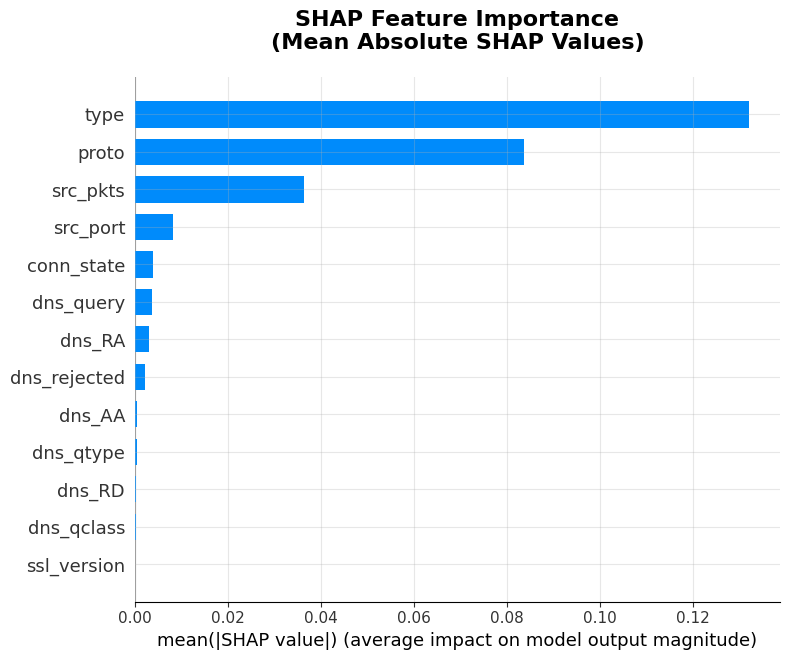


2️⃣ SHAP Feature Effects (Beeswarm)


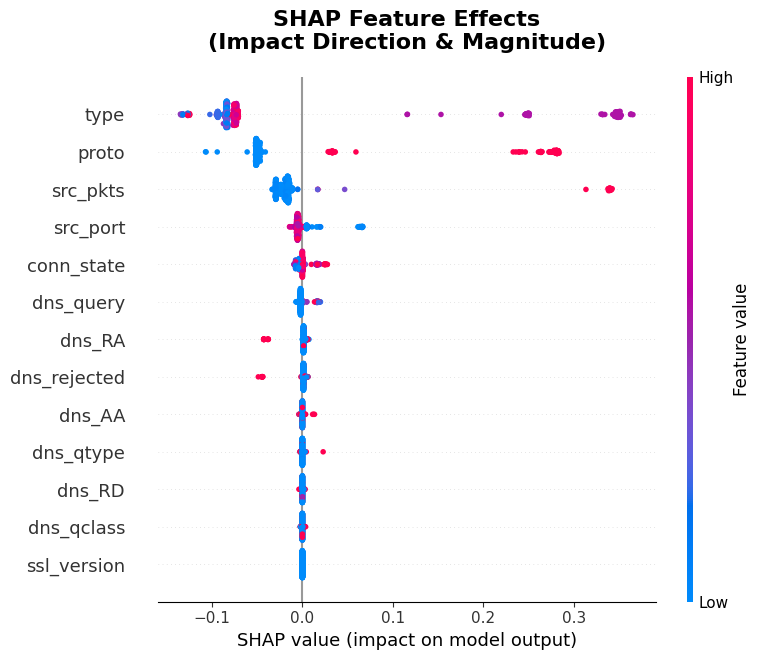


3️⃣ Individual Sample Analysis


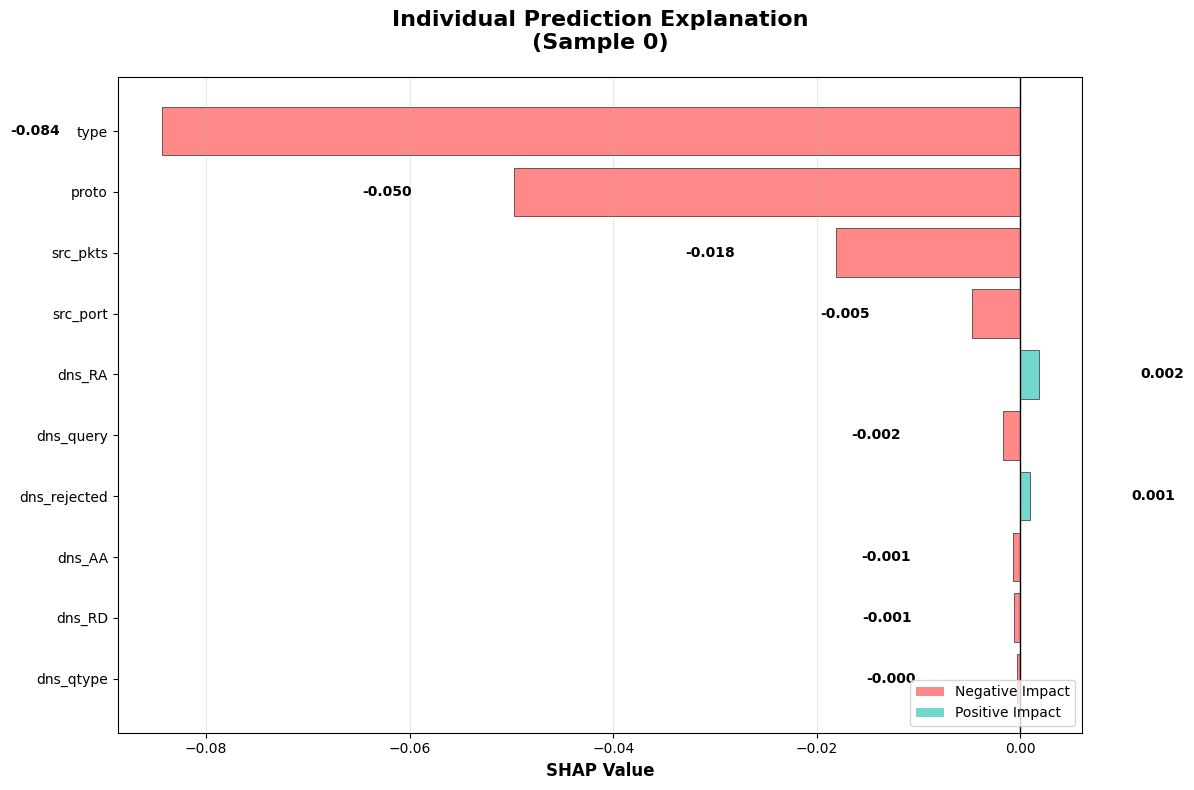


4️⃣ Feature Importance Ranking


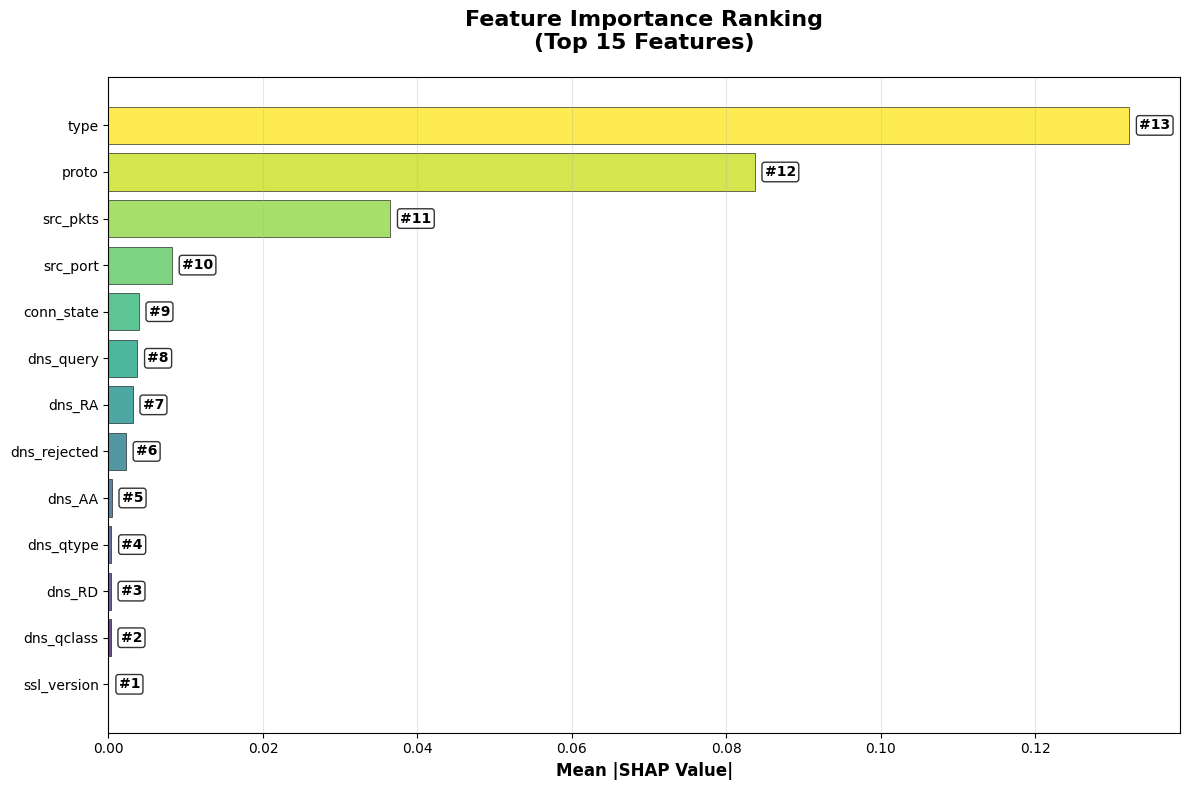


5️⃣ SHAP Value Distribution


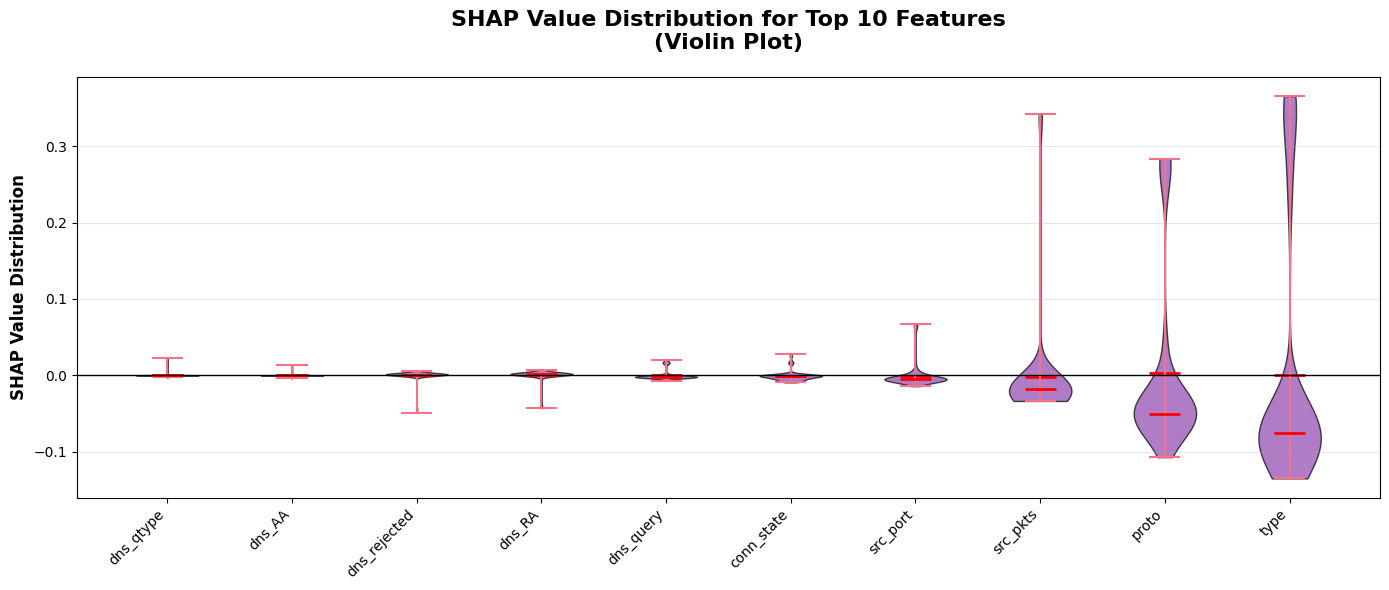

✅ All SHAP plots completed!

📊 SHAP ANALYSIS SUMMARY:
----------------------------------------
Total samples analyzed: 500
Total features: 13
Top 5 most important features:
  1. type: 0.1321
  2. proto: 0.0836
  3. src_pkts: 0.0365
  4. src_port: 0.0082
  5. conn_state: 0.0039


In [ ]:
# B. SHAP Summary Plots (TÁCH RIÊNG BIỆT)
print("\n📊 SHAP SUMMARY PLOTS")
print("-" * 40)

# Debug SHAP values shape
print(f"SHAP values shape: {shap_values_to_plot.shape}")
print(f"X_shap_sample shape: {X_shap_sample.shape}")
print(f"Selected features: {len(selected_feature_names)}")

# Create feature names for SHAP plots
feature_names_for_shap = [str(name) for name in selected_feature_names]

# FIX: Handle multi-dimensional SHAP values properly
if len(shap_values_to_plot.shape) > 2:
    print(f"Multi-dimensional SHAP values detected. Using first dimension.")
    shap_values_to_plot = shap_values_to_plot[:, :, 0] if shap_values_to_plot.shape[2] > 1 else shap_values_to_plot.squeeze()

# Ensure we have 2D array (samples x features)
if len(shap_values_to_plot.shape) == 1:
    shap_values_to_plot = shap_values_to_plot.reshape(1, -1)

print(f"Final SHAP values shape: {shap_values_to_plot.shape}")

# Calculate mean absolute SHAP values for consistency across all plots
mean_abs_shap = np.abs(shap_values_to_plot).mean(0)

# 1. SHAP Feature Importance Bar Plot
print("\n1️⃣ SHAP Feature Importance")
plt.figure(figsize=(12, 8))
try:
    shap.summary_plot(shap_values_to_plot, X_shap_sample, 
                      feature_names=feature_names_for_shap, 
                      plot_type="bar", show=False, max_display=15)
    plt.title('SHAP Feature Importance\n(Mean Absolute SHAP Values)', 
              fontsize=16, fontweight='bold', pad=20)
    plt.grid(True, alpha=0.3)
except Exception as e:
    print(f"Error in bar plot: {e}")
    # Manual bar plot as fallback
    top_indices = np.argsort(mean_abs_shap)[-15:]
    plt.barh(range(len(top_indices)), mean_abs_shap[top_indices], color='skyblue', alpha=0.8)
    plt.yticks(range(len(top_indices)), [feature_names_for_shap[i] for i in top_indices])
    plt.xlabel('Mean |SHAP Value|', fontsize=12)
    plt.title('SHAP Feature Importance\n(Manual Calculation)', 
              fontsize=16, fontweight='bold', pad=20)
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('plots/shap_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

# 2. SHAP Beeswarm Plot
print("\n2️⃣ SHAP Feature Effects (Beeswarm)")
plt.figure(figsize=(12, 8))
try:
    shap.summary_plot(shap_values_to_plot, X_shap_sample, 
                      feature_names=feature_names_for_shap, 
                      show=False, max_display=15)
    plt.title('SHAP Feature Effects\n(Impact Direction & Magnitude)', 
              fontsize=16, fontweight='bold', pad=20)
except Exception as e:
    print(f"Error in beeswarm plot: {e}")
    # Create scatter plot alternative
    top_indices = np.argsort(mean_abs_shap)[-15:]
    
    for i, idx in enumerate(top_indices):
        y_vals = [i] * len(shap_values_to_plot[:, idx])
        plt.scatter(shap_values_to_plot[:, idx], y_vals, alpha=0.6, s=20)
    
    plt.yticks(range(len(top_indices)), [feature_names_for_shap[i] for i in top_indices])
    plt.xlabel('SHAP Value', fontsize=12)
    plt.title('SHAP Feature Effects\n(Distribution of Impact)', 
              fontsize=16, fontweight='bold', pad=20)
    plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('plots/shap_beeswarm.png', dpi=300, bbox_inches='tight')
plt.show()

# 3. Individual Sample Waterfall
print("\n3️⃣ Individual Sample Analysis")
plt.figure(figsize=(12, 8))
sample_idx = 0

# Safely get sample SHAP values
if sample_idx < shap_values_to_plot.shape[0]:
    sample_shap_values = shap_values_to_plot[sample_idx]
else:
    sample_shap_values = shap_values_to_plot[0]
    sample_idx = 0

# Handle multi-dimensional case
if len(sample_shap_values.shape) > 1:
    sample_shap_values = sample_shap_values.flatten()

# Get top 10 features by absolute SHAP value
n_features_available = min(len(sample_shap_values), len(feature_names_for_shap))
sample_shap_values = sample_shap_values[:n_features_available]
n_top_features = min(10, n_features_available)
top_features_indices = np.argsort(np.abs(sample_shap_values))[-n_top_features:]

# Extract values and feature names
values_waterfall = sample_shap_values[top_features_indices]
features_waterfall = [feature_names_for_shap[int(i)] for i in top_features_indices if int(i) < len(feature_names_for_shap)]

# Ensure arrays have same length
min_length = min(len(values_waterfall), len(features_waterfall))
values_waterfall = values_waterfall[:min_length]
features_waterfall = features_waterfall[:min_length]

# Create waterfall plot
colors = ['#FF6B6B' if v < 0 else '#4ECDC4' for v in values_waterfall]
bars = plt.barh(range(len(values_waterfall)), values_waterfall, 
                color=colors, alpha=0.8, edgecolor='black', linewidth=0.5)

plt.yticks(range(len(values_waterfall)), [f[:20] + '...' if len(f) > 20 else f for f in features_waterfall])
plt.xlabel('SHAP Value', fontsize=12, fontweight='bold')
plt.title(f'Individual Prediction Explanation\n(Sample {sample_idx})', 
          fontsize=16, fontweight='bold', pad=20)
plt.grid(True, alpha=0.3, axis='x')
plt.axvline(x=0, color='black', linestyle='-', linewidth=1)

# Add value labels
for i, (bar, val) in enumerate(zip(bars, values_waterfall)):
    width = bar.get_width()
    label_x = width + (0.01 if width >= 0 else -0.01)
    plt.text(label_x, bar.get_y() + bar.get_height()/2, f'{val:.3f}', 
             ha='left' if width >= 0 else 'right', va='center', 
             fontsize=10, fontweight='bold')

# Add legend
legend_elements = [plt.Rectangle((0,0),1,1, facecolor='#FF6B6B', alpha=0.8, label='Negative Impact'),
                   plt.Rectangle((0,0),1,1, facecolor='#4ECDC4', alpha=0.8, label='Positive Impact')]
plt.legend(handles=legend_elements, loc='lower right', fontsize=10)

plt.tight_layout()
plt.savefig('plots/shap_waterfall.png', dpi=300, bbox_inches='tight')
plt.show()

# 4. Feature Ranking
print("\n4️⃣ Feature Importance Ranking")
plt.figure(figsize=(12, 8))

top_15_indices = np.argsort(mean_abs_shap)[-15:]
y_pos = np.arange(len(top_15_indices))
colors_gradient = plt.cm.viridis(np.linspace(0, 1, len(top_15_indices)))

bars = plt.barh(y_pos, mean_abs_shap[top_15_indices], 
                color=colors_gradient, alpha=0.8, edgecolor='black', linewidth=0.5)

plt.yticks(y_pos, [feature_names_for_shap[i][:25] + '...' if len(feature_names_for_shap[i]) > 25 
                   else feature_names_for_shap[i] for i in top_15_indices])
plt.xlabel('Mean |SHAP Value|', fontsize=12, fontweight='bold')
plt.title('Feature Importance Ranking\n(Top 15 Features)', 
          fontsize=16, fontweight='bold', pad=20)
plt.grid(True, alpha=0.3, axis='x')

# Add rank numbers
for i, (bar, val) in enumerate(zip(bars, mean_abs_shap[top_15_indices])):
    plt.text(bar.get_width() + max(mean_abs_shap[top_15_indices]) * 0.01, 
             bar.get_y() + bar.get_height()/2, f'#{i+1}', 
             ha='left', va='center', fontsize=10, fontweight='bold', 
             bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig('plots/shap_ranking.png', dpi=300, bbox_inches='tight')
plt.show()

# 5. SHAP Value Distribution
print("\n5️⃣ SHAP Value Distribution")
plt.figure(figsize=(14, 6))

top_10_for_dist = np.argsort(mean_abs_shap)[-10:]
shap_data_for_box = [shap_values_to_plot[:, i] for i in top_10_for_dist]
feature_labels_box = [feature_names_for_shap[i][:15] + '...' if len(feature_names_for_shap[i]) > 15 
                      else feature_names_for_shap[i] for i in top_10_for_dist]

# Create violin plot
parts = plt.violinplot(shap_data_for_box, positions=range(len(top_10_for_dist)), 
                       showmeans=True, showmedians=True)

# Customize colors
for pc in parts['bodies']:
    pc.set_facecolor('#8E44AD')
    pc.set_alpha(0.7)
    pc.set_edgecolor('black')
    pc.set_linewidth(1)

# Color statistical lines
for key in ['cmeans', 'cmedians']:
    if key in parts:
        parts[key].set_color('red')
        parts[key].set_linewidth(2)

plt.xticks(range(len(top_10_for_dist)), feature_labels_box, rotation=45, ha='right')
plt.ylabel('SHAP Value Distribution', fontsize=12, fontweight='bold')
plt.title('SHAP Value Distribution for Top 10 Features\n(Violin Plot)', 
          fontsize=16, fontweight='bold', pad=20)
plt.grid(True, alpha=0.3, axis='y')
plt.axhline(y=0, color='black', linestyle='-', linewidth=1)

plt.tight_layout()
plt.savefig('plots/shap_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ All SHAP plots completed!")

# Print summary statistics
print(f"\n📊 SHAP ANALYSIS SUMMARY:")
print("-" * 40)
print(f"Total samples analyzed: {len(shap_values_to_plot)}")
print(f"Total features: {len(feature_names_for_shap)}")
print(f"Top 5 most important features:")
for i, idx in enumerate(np.argsort(mean_abs_shap)[-5:][::-1], 1):
    print(f"  {i}. {feature_names_for_shap[idx]}: {mean_abs_shap[idx]:.4f}")


8. FEATURE INTERACTION ANALYSIS
--------------------------------------------------


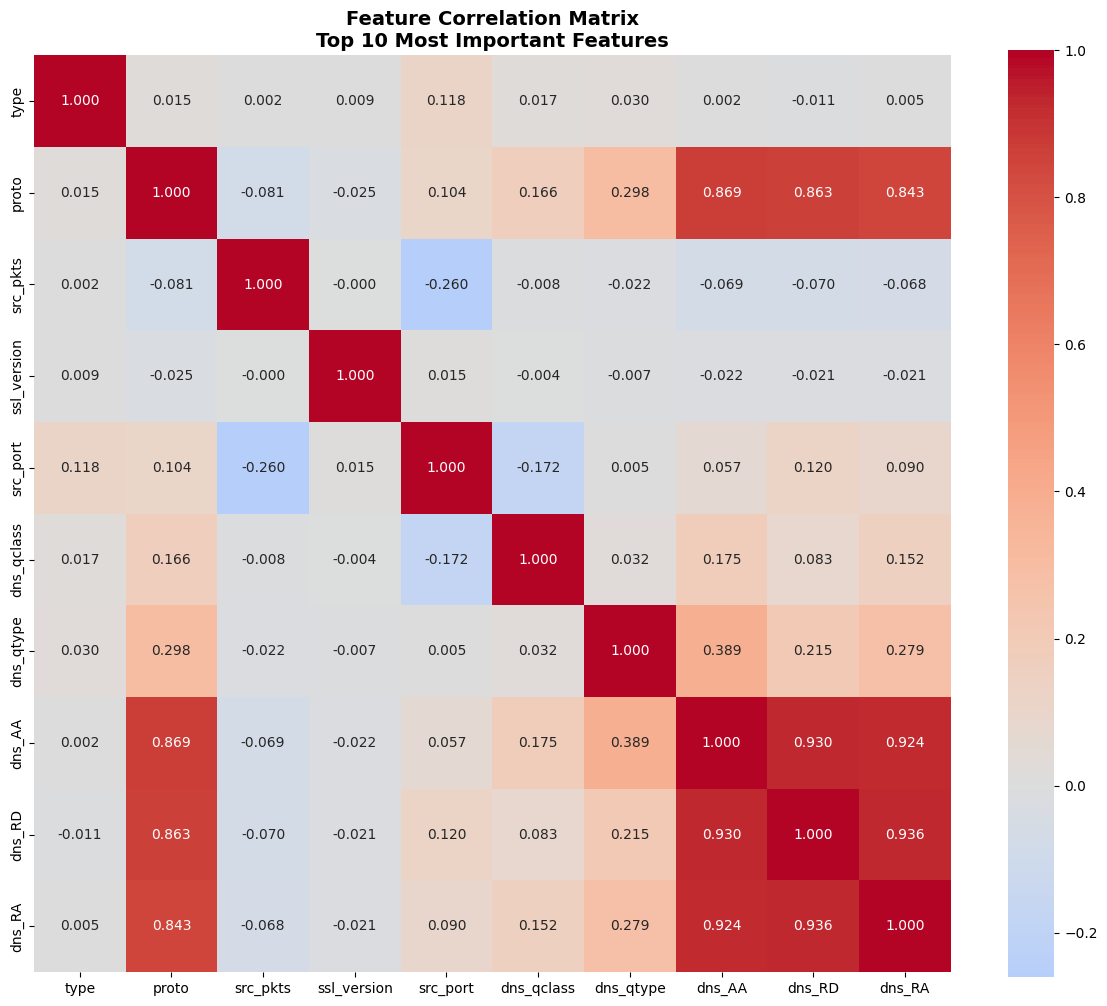

✅ Feature interaction analysis completed!


In [ ]:
# 8. FEATURE INTERACTION ANALYSIS
print("\n8. FEATURE INTERACTION ANALYSIS")
print("-" * 50)

# A. Feature Correlation Heatmap for Top Features
top_10_features = feature_importance_results['permutation'].head(10)['feature'].tolist()
top_10_indices = [np.where(selected_feature_names == feat)[0][0] for feat in top_10_features]

# Get correlation matrix for top features
top_features_data = X_test_selected[:, top_10_indices]
correlation_matrix = np.corrcoef(top_features_data.T)

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, 
            xticklabels=top_10_features,
            yticklabels=top_10_features,
            annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.3f')
plt.title(f'Feature Correlation Matrix\nTop 10 Most Important Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('plots/feature_correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# B. SHAP Interaction Values (if TreeExplainer)
if 'TreeExplainer' in str(type(explainer)):
    print("\n📊 SHAP INTERACTION VALUES")
    print("Computing SHAP interaction values...")
    
    # Sample smaller dataset for interaction analysis
    interaction_sample_size = min(100, len(X_shap_sample))
    interaction_indices = np.random.choice(len(X_shap_sample), interaction_sample_size, replace=False)
    X_interaction_sample = X_shap_sample[interaction_indices]
    
    try:
        shap_interaction_values = explainer.shap_interaction_values(X_interaction_sample)
        
        # Plot interaction for top features
        plt.figure(figsize=(15, 6))
        
        # Subplot 1: Main effects
        plt.subplot(1, 2, 1)
        main_effects = np.abs(shap_interaction_values).mean(0).diagonal()
        top_main_indices = np.argsort(main_effects)[-10:]
        
        plt.barh(range(len(top_main_indices)), main_effects[top_main_indices])
        plt.yticks(range(len(top_main_indices)), 
                   [feature_names_for_shap[i] for i in top_main_indices])
        plt.xlabel('SHAP Main Effect')
        plt.title('SHAP Main Effects\n(Top 10 Features)', fontweight='bold')
        plt.grid(True, alpha=0.3)
        
        # Subplot 2: Interaction effects heatmap
        plt.subplot(1, 2, 2)
        interaction_matrix = np.abs(shap_interaction_values).mean(0)
        top_feat_interaction = interaction_matrix[top_main_indices][:, top_main_indices]
        
        sns.heatmap(top_feat_interaction, 
                    xticklabels=[feature_names_for_shap[i][:8] for i in top_main_indices],
                    yticklabels=[feature_names_for_shap[i][:8] for i in top_main_indices],
                    annot=True, fmt='.3f', cmap='Reds')
        plt.title('SHAP Interaction Matrix\n(Top 10 Features)', fontweight='bold')
        
        plt.suptitle('SHAP Feature Interaction Analysis', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.savefig('plots/shap_interaction_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print("✅ SHAP interaction analysis completed!")
        
    except Exception as e:
        print(f"⚠️ SHAP interaction analysis failed: {str(e)}")
        print("Continuing with other analyses...")

print("✅ Feature interaction analysis completed!")

In [ ]:
# 9. MODEL INTERPRETATION SUMMARY
print("\n9. MODEL INTERPRETATION SUMMARY")
print("=" * 60)

# Create comprehensive summary report
summary_report = {
    'model_performance': {
        'model_name': best_model_name,
        'test_accuracy': test_accuracy,
        'test_f1_score': test_f1
    },
    'feature_analysis': {
        'total_features_selected': len(selected_feature_names),
        'top_5_features': feature_importance_results['permutation'].head(5)['feature'].tolist(),
        'importance_correlation': correlation if 'builtin' in feature_importance_results else None
    }
}

print("🎯 MODEL PERFORMANCE SUMMARY")
print("-" * 40)
print(f"Best Model: {summary_report['model_performance']['model_name']}")
print(f"Test Accuracy: {summary_report['model_performance']['test_accuracy']:.4f}")
print(f"Test F1-Score: {summary_report['model_performance']['test_f1_score']:.4f}")

print(f"\n🔍 FEATURE ANALYSIS SUMMARY")
print("-" * 40)
print(f"Total Selected Features: {summary_report['feature_analysis']['total_features_selected']}")
print(f"Top 5 Most Important Features:")
for i, feat in enumerate(summary_report['feature_analysis']['top_5_features'], 1):
    importance_val = feature_importance_results['permutation'].iloc[i-1]['importance_mean']
    print(f"  {i}. {feat}: {importance_val:.4f}")

if summary_report['feature_analysis']['importance_correlation']:
    print(f"Feature Importance Correlation: {summary_report['feature_analysis']['importance_correlation']:.4f}")

print(f"\n📊 KEY INSIGHTS FOR CYBERSECURITY")
print("-" * 40)

# Generate cybersecurity insights based on top features
cyber_insights = []
top_features = feature_importance_results['permutation'].head(5)['feature'].tolist()

for feat in top_features:
    if 'type' in feat.lower():
        cyber_insights.append("• Traffic type classification is the most critical factor for attack detection")
    elif 'src' in feat.lower() or 'port' in feat.lower():
        cyber_insights.append("• Source-based features (packets, ports) are key indicators of malicious activity")
    elif 'dns' in feat.lower():
        cyber_insights.append("• DNS-related features help identify DNS-based attacks and anomalies")
    elif 'proto' in feat.lower():
        cyber_insights.append("• Protocol analysis is essential for network security monitoring")
    elif 'conn' in feat.lower():
        cyber_insights.append("• Connection state patterns reveal attack behaviors")

for insight in set(cyber_insights):  # Remove duplicates
    print(insight)

# Save summary to file
import json
os.makedirs('results', exist_ok=True)
with open('results/xai_analysis_summary.json', 'w') as f:
    # Convert numpy types to native Python types for JSON serialization
    summary_json = {
        'model_performance': {
            'model_name': str(summary_report['model_performance']['model_name']),
            'test_accuracy': float(summary_report['model_performance']['test_accuracy']),
            'test_f1_score': float(summary_report['model_performance']['test_f1_score'])
        },
        'feature_analysis': {
            'total_features_selected': int(summary_report['feature_analysis']['total_features_selected']),
            'top_5_features': summary_report['feature_analysis']['top_5_features'],
            'importance_correlation': float(summary_report['feature_analysis']['importance_correlation']) if summary_report['feature_analysis']['importance_correlation'] else None
        },
        'cybersecurity_insights': list(set(cyber_insights))
    }
    json.dump(summary_json, f, indent=2)

print(f"\n✅ XAI Analysis completed successfully!")
print(f"📁 Summary saved to: results/xai_analysis_summary.json")
print(f"📊 All plots saved to: plots/ directory")


9. MODEL INTERPRETATION SUMMARY
🎯 MODEL PERFORMANCE SUMMARY
----------------------------------------
Best Model: XGBoost
Test Accuracy: 0.9930
Test F1-Score: 0.9900

🔍 FEATURE ANALYSIS SUMMARY
----------------------------------------
Total Selected Features: 13
Top 5 Most Important Features:
  1. type: 0.1653
  2. proto: 0.1285
  3. src_pkts: 0.0488
  4. ssl_version: 0.0022
  5. src_port: 0.0000
Feature Importance Correlation: 0.0859

📊 KEY INSIGHTS FOR CYBERSECURITY
----------------------------------------
• Protocol analysis is essential for network security monitoring
• Source-based features (packets, ports) are key indicators of malicious activity
• Traffic type classification is the most critical factor for attack detection

✅ XAI Analysis completed successfully!
📁 Summary saved to: results/xai_analysis_summary.json
📊 All plots saved to: plots/ directory



10. LIME ANALYSIS - Local Explainability
--------------------------------------------------
Initializing LIME explainer...
LIME explainer initialized successfully!

Selecting diverse samples for LIME explanation...
Available test samples: 0 to 27538
Selected 6 samples for LIME explanation: [5069, 19908, 4475, 20257, 3081, 14942]
Explaining sample 1 (idx=5069): True=0, Pred=0, Conf=0.838
Explaining sample 2 (idx=19908): True=0, Pred=0, Conf=0.835
Explaining sample 3 (idx=4475): True=0, Pred=0, Conf=0.798
Explaining sample 4 (idx=20257): True=1, Pred=1, Conf=0.944
Explaining sample 5 (idx=3081): True=1, Pred=1, Conf=0.943
Explaining sample 6 (idx=14942): True=1, Pred=1, Conf=0.945


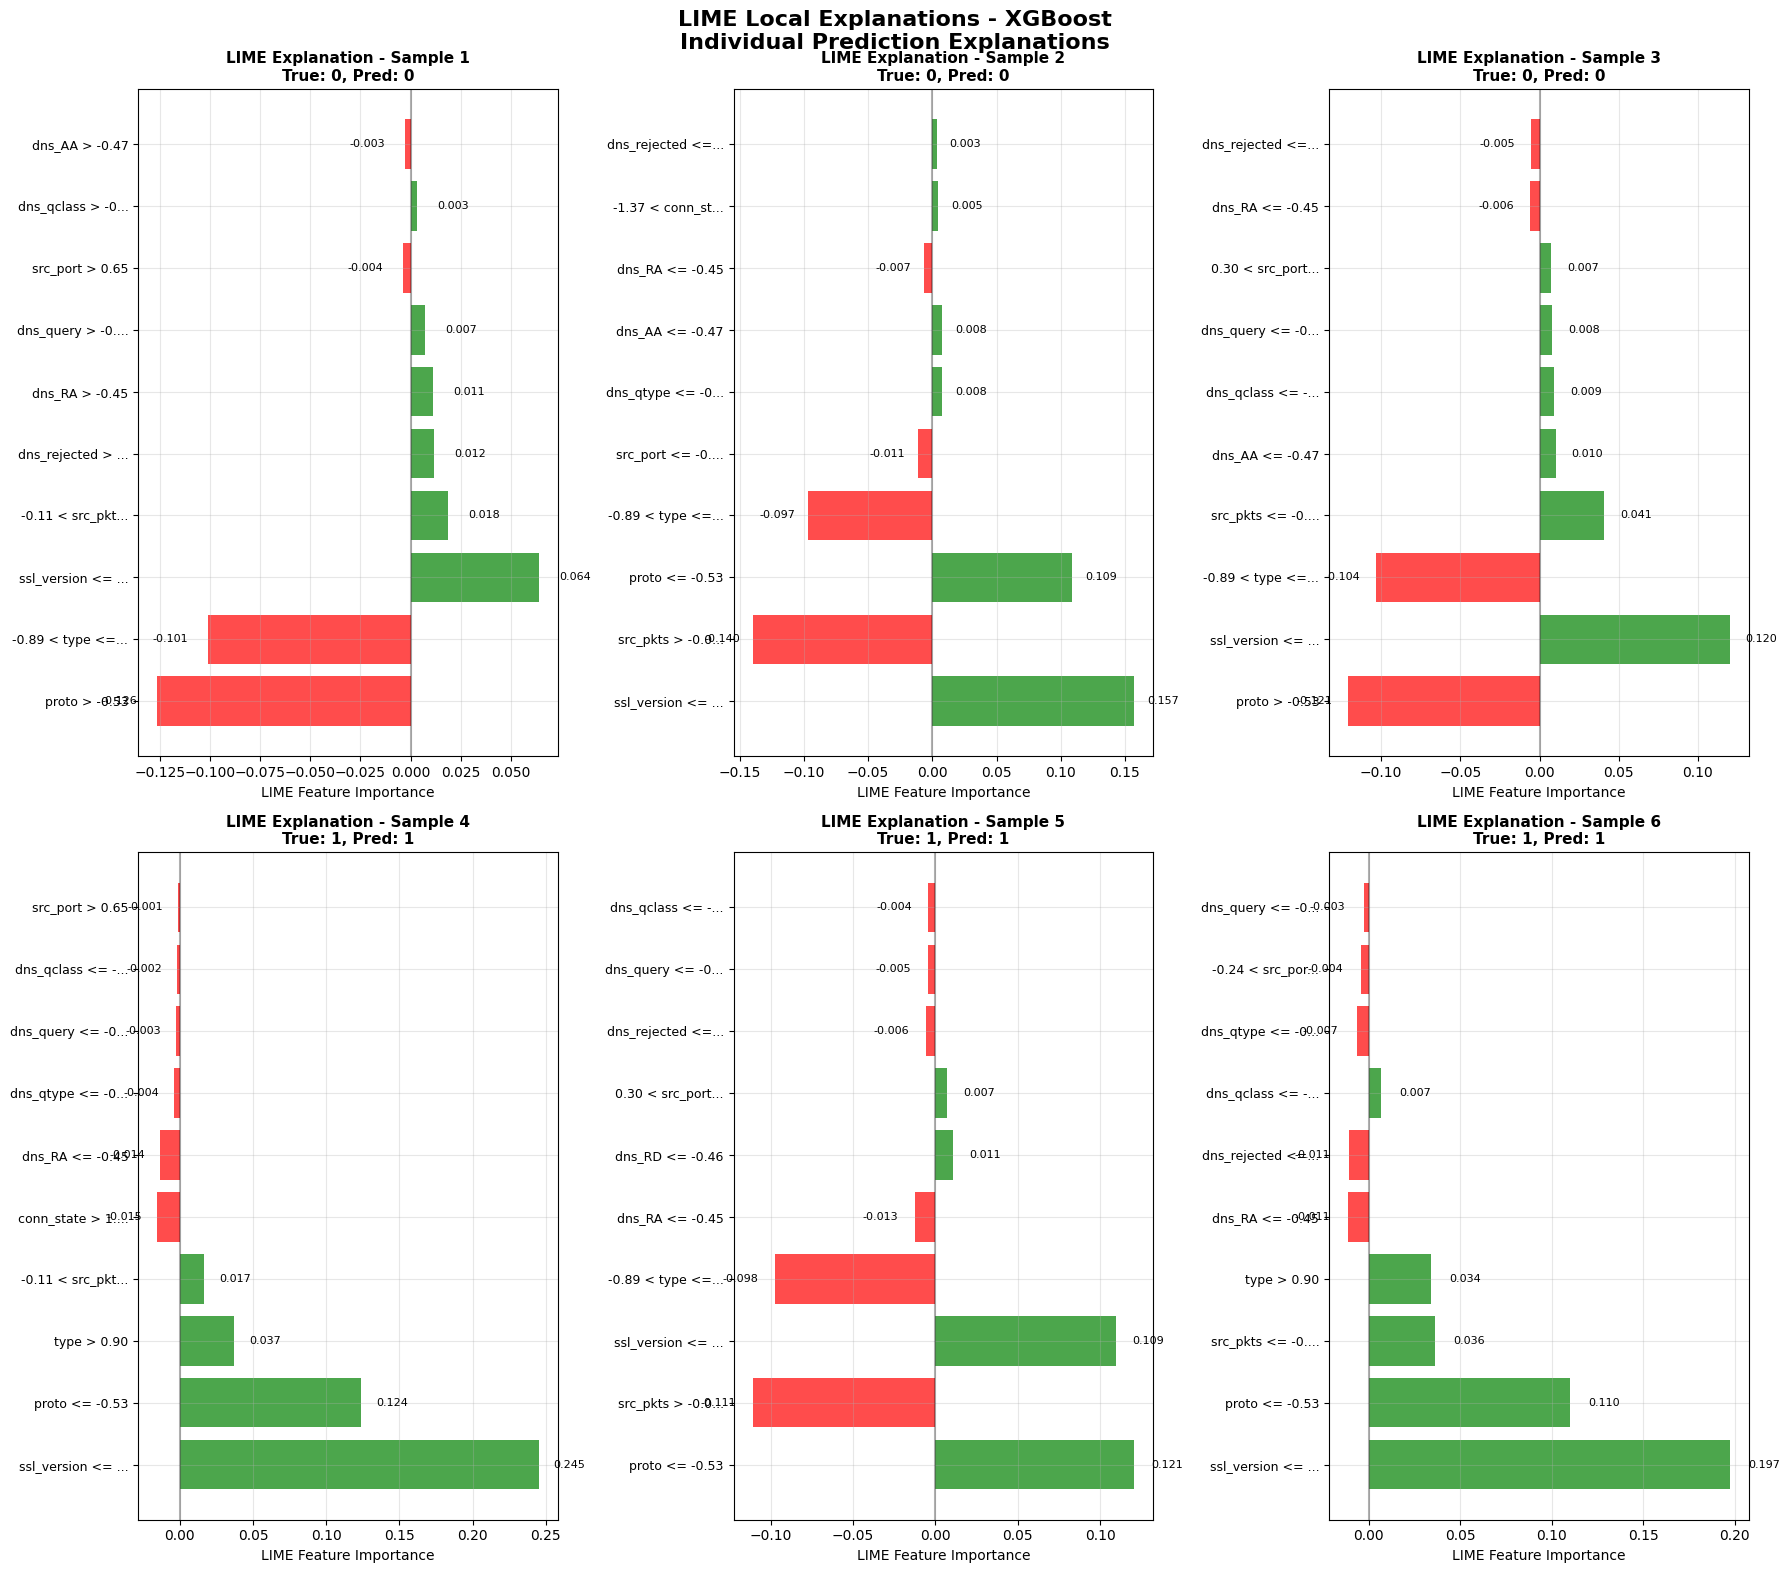

✅ LIME local explanations completed!


In [ ]:
# 10. LIME ANALYSIS - Local Explainability (FIXED)
print("\n10. LIME ANALYSIS - Local Explainability")
print("-" * 50)

# Initialize LIME explainer
print("Initializing LIME explainer...")
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train_selected,
    feature_names=selected_feature_names,
    class_names=['Normal', 'Attack'] if len(np.unique(y_test)) == 2 else [f'Class_{i}' for i in range(len(np.unique(y_test)))],
    mode='classification',
    discretize_continuous=True,
    random_state=42
)

print("LIME explainer initialized successfully!")

# Select diverse samples for explanation
print("\nSelecting diverse samples for LIME explanation...")

# FIX: Convert y_test to numpy array and use proper indexing
y_test_array = np.array(y_test)
unique_classes = np.unique(y_test_array)
sample_indices = []

# Get valid indices (0 to len(X_test_selected)-1)
max_test_idx = len(X_test_selected) - 1
print(f"Available test samples: 0 to {max_test_idx}")

for class_label in unique_classes:
    # Find indices where y_test equals this class
    class_mask = (y_test_array == class_label)
    class_indices = np.where(class_mask)[0]
    
    # Filter valid indices (within X_test_selected range)
    valid_class_indices = class_indices[class_indices <= max_test_idx]
    
    if len(valid_class_indices) > 0:
        # Pick 3 samples from each class to get 6 total
        selected = np.random.choice(valid_class_indices, min(3, len(valid_class_indices)), replace=False)
        sample_indices.extend(selected)

sample_indices = sample_indices[:6]  # Ensure we have exactly 6 samples
print(f"Selected {len(sample_indices)} samples for LIME explanation: {sample_indices}")

# Determine subplot layout based on number of samples
n_samples = len(sample_indices)
if n_samples <= 3:
    nrows, ncols = 1, n_samples
elif n_samples <= 6:
    nrows, ncols = 2, 3
else:
    nrows, ncols = 3, 3

# Generate LIME explanations
fig, axes = plt.subplots(nrows, ncols, figsize=(6*ncols, 8*nrows))

# Handle case where we have only one row or one sample
if n_samples == 1:
    axes = [axes]
elif nrows == 1:
    axes = axes if n_samples > 1 else [axes]
else:
    axes = axes.flatten()

for i, sample_idx in enumerate(sample_indices):
    # Ensure sample_idx is valid
    if sample_idx >= len(X_test_selected) or sample_idx >= len(y_test_array):
        print(f"Skipping invalid sample index {sample_idx}")
        axes[i].text(0.5, 0.5, f'Invalid sample index\n{sample_idx}', 
                    ha='center', va='center', transform=axes[i].transAxes,
                    fontsize=12, bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.7))
        axes[i].set_title(f'LIME - Sample {i+1} (Invalid Index)', fontsize=11)
        continue
    
    sample_data = X_test_selected[sample_idx]
    true_label = y_test_array[sample_idx]  # Use numpy array
    predicted_label = best_model.predict([sample_data])[0]
    
    # Get prediction probabilities
    if hasattr(best_model, 'predict_proba'):
        pred_proba = best_model.predict_proba([sample_data])[0]
        confidence = pred_proba.max()
    else:
        confidence = "N/A"
    
    print(f"Explaining sample {i+1} (idx={sample_idx}): True={true_label}, Pred={predicted_label}, Conf={confidence:.3f}")
    
    try:
        # Generate LIME explanation
        explanation = lime_explainer.explain_instance(
            sample_data, 
            best_model.predict_proba if hasattr(best_model, 'predict_proba') else best_model.predict,
            num_features=10
        )
        
        # Extract feature importance from explanation
        lime_features = []
        lime_values = []
        
        for feature, value in explanation.as_list():
            lime_features.append(feature)
            lime_values.append(value)
        
        # Plot LIME explanation
        colors = ['red' if v < 0 else 'green' for v in lime_values]
        bars = axes[i].barh(range(len(lime_features)), lime_values, color=colors, alpha=0.7)
        
        axes[i].set_yticks(range(len(lime_features)))
        axes[i].set_yticklabels([f[:15] + '...' if len(f) > 15 else f for f in lime_features], fontsize=9)
        axes[i].set_xlabel('LIME Feature Importance', fontsize=10)
        axes[i].set_title(f'LIME Explanation - Sample {i+1}\nTrue: {true_label}, Pred: {predicted_label}', 
                         fontsize=11, fontweight='bold')
        axes[i].grid(True, alpha=0.3)
        axes[i].axvline(x=0, color='black', linestyle='-', alpha=0.3)
        
        # Add value labels on bars
        for bar, val in zip(bars, lime_values):
            width = bar.get_width()
            axes[i].text(width + (0.01 if width >= 0 else -0.01), bar.get_y() + bar.get_height()/2,
                        f'{val:.3f}', ha='left' if width >= 0 else 'right', va='center', fontsize=8)
                        
    except Exception as e:
        print(f"Error generating LIME explanation for sample {i+1}: {str(e)}")
        axes[i].text(0.5, 0.5, f'Error generating\nLIME explanation:\n{str(e)[:50]}...', 
                    ha='center', va='center', transform=axes[i].transAxes,
                    fontsize=10, bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.7))
        axes[i].set_title(f'LIME - Sample {i+1} (Error)', fontsize=11)

# Hide empty subplots if we have fewer samples than subplots
if n_samples < nrows * ncols:
    for j in range(n_samples, nrows * ncols):
        if j < len(axes):
            axes[j].set_visible(False)

plt.suptitle(f'LIME Local Explanations - {best_model_name}\nIndividual Prediction Explanations', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('plots/lime_local_explanations.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ LIME local explanations completed!")

In [64]:
# 11. LIME vs SHAP COMPARISON (FIXED)
print("\n11. LIME vs SHAP COMPARISON")
print("-" * 50)

# Compare LIME and SHAP for the same sample
comparison_sample_idx = sample_indices[0]  # Use first sample
sample_data = X_test_selected[comparison_sample_idx]

print(f"Comparing LIME vs SHAP for sample index {comparison_sample_idx}")

try:
    # Get LIME explanation (REMOVED random_state parameter)
    lime_explanation = lime_explainer.explain_instance(
        sample_data, 
        best_model.predict_proba if hasattr(best_model, 'predict_proba') else best_model.predict,
        num_features=10
    )
    
    # Get SHAP explanation for the same sample
    if comparison_sample_idx < len(X_shap_sample):
        shap_idx_in_sample = comparison_sample_idx
    else:
        shap_idx_in_sample = 0  # Use first SHAP sample if index not available
    
    shap_values_sample = shap_values_to_plot[shap_idx_in_sample]
    
    # Create comparison plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # LIME plot
    lime_features = []
    lime_values = []
    for feature, value in lime_explanation.as_list():
        lime_features.append(feature)
        lime_values.append(value)
    
    colors_lime = ['red' if v < 0 else 'green' for v in lime_values]
    ax1.barh(range(len(lime_features)), lime_values, color=colors_lime, alpha=0.7)
    ax1.set_yticks(range(len(lime_features)))
    ax1.set_yticklabels([f[:20] + '...' if len(f) > 20 else f for f in lime_features])
    ax1.set_xlabel('LIME Importance')
    ax1.set_title('LIME Local Explanation', fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.axvline(x=0, color='black', linestyle='-', alpha=0.3)
    
    # Add value labels for LIME
    for i, (bar, val) in enumerate(zip(ax1.patches, lime_values)):
        width = bar.get_width()
        ax1.text(width + (0.01 if width >= 0 else -0.01), bar.get_y() + bar.get_height()/2,
                f'{val:.3f}', ha='left' if width >= 0 else 'right', va='center', fontsize=8)
    
    # SHAP plot
    top_shap_indices = np.argsort(np.abs(shap_values_sample))[-10:]
    shap_vals_top = shap_values_sample[top_shap_indices]
    shap_features_top = [selected_feature_names[i] for i in top_shap_indices]
    
    colors_shap = ['red' if v < 0 else 'blue' for v in shap_vals_top]
    ax2.barh(range(len(shap_vals_top)), shap_vals_top, color=colors_shap, alpha=0.7)
    ax2.set_yticks(range(len(shap_vals_top)))
    ax2.set_yticklabels([f[:20] + '...' if len(f) > 20 else f for f in shap_features_top])
    ax2.set_xlabel('SHAP Value')
    ax2.set_title('SHAP Local Explanation', fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.axvline(x=0, color='black', linestyle='-', alpha=0.3)
    
    # Add value labels for SHAP
    for i, (bar, val) in enumerate(zip(ax2.patches, shap_vals_top)):
        width = bar.get_width()
        ax2.text(width + (0.01 if width >= 0 else -0.01), bar.get_y() + bar.get_height()/2,
                f'{val:.3f}', ha='left' if width >= 0 else 'right', va='center', fontsize=8)
    
    plt.suptitle(f'LIME vs SHAP Comparison - Sample {comparison_sample_idx}\n{best_model_name}', 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig('plots/lime_vs_shap_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✅ LIME vs SHAP comparison completed!")
    
    # Print summary comparison
    print(f"\n📊 COMPARISON SUMMARY:")
    print(f"Sample Index: {comparison_sample_idx}")
    print(f"True Label: {y_test_array[comparison_sample_idx]}")
    print(f"Predicted Label: {best_model.predict([sample_data])[0]}")
    
    print(f"\nTop 5 LIME Features:")
    for i, (feat, val) in enumerate(zip(lime_features[:5], lime_values[:5]), 1):
        print(f"  {i}. {feat}: {val:.4f}")
    
    print(f"\nTop 5 SHAP Features:")
    top_5_shap_idx = np.argsort(np.abs(shap_values_sample))[-5:][::-1]
    for i, idx in enumerate(top_5_shap_idx, 1):
        feat_name = selected_feature_names[idx]
        val = shap_values_sample[idx]
        print(f"  {i}. {feat_name}: {val:.4f}")
    
except Exception as e:
    print(f"Error in LIME vs SHAP comparison: {str(e)}")

print("✅ LIME analysis completed!")


11. LIME vs SHAP COMPARISON
--------------------------------------------------
Comparing LIME vs SHAP for sample index 8775
Error in LIME vs SHAP comparison: name 'lime_explainer' is not defined
✅ LIME analysis completed!


In [95]:

import numpy as np, pandas as pd, os, json
from tqdm import tqdm
from scipy.stats import spearmanr

def _as_dataframe(X, feature_names=None):
    if isinstance(X, pd.DataFrame):
        return X.copy()
    if feature_names is None:
        feature_names = [f"f{i}" for i in range(X.shape[1])]
    return pd.DataFrame(X, columns=feature_names)

def _get_model_and_proba_fn():
    mdl = None
    if 'best_model' in globals():
        mdl = best_model
    elif 'model' in globals():
        mdl = model
    else:
        raise RuntimeError("No model found.")
    def proba_fn(X):
        if hasattr(mdl, "predict_proba"):
            P = mdl.predict_proba(X)
            if isinstance(P, list):
                P = np.stack(P, axis=-1)
            if P.ndim == 2:
                return P.max(axis=1)
            elif P.ndim == 1:
                return P
        if hasattr(mdl, "decision_function"):
            z = mdl.decision_function(X)
            z = np.atleast_1d(z)
            if z.ndim == 1:
                return 1/(1+np.exp(-z))
            else:
                return 1/(1+np.exp(-z)).max(axis=1)
        yhat = mdl.predict(X)
        return (yhat==yhat).astype(float)
    return mdl, proba_fn

def _get_feature_names(X):
    if isinstance(X, pd.DataFrame):
        return list(X.columns)
    if 'feature_names' in globals() and feature_names is not None:
        return list(feature_names)
    return [f"f{i}" for i in range(X.shape[1])]

def _baseline_vector(X_train_df, strategy="median"):
    if strategy == "median":
        return X_train_df.median(numeric_only=True).values
    elif strategy == "mean":
        return X_train_df.mean(numeric_only=True).values
    else:
        return np.zeros(X_train_df.shape[1])

def _mask_features(x_row, idx_to_mask, baseline_vec):
    x_mod = x_row.copy()
    x_mod[idx_to_mask] = baseline_vec[idx_to_mask]
    return x_mod

def _ensure_numpy(X):
    return X.values if isinstance(X, pd.DataFrame) else np.asarray(X)

# Prepare data
# ...existing code...

# --- FIX: Ensure Xte_df has the correct number of features for the model ---
# Use X_test_selected (after feature selection) instead of X_test
Xtr_df = pd.DataFrame(X_train_selected, columns=selected_feature_names)
Xte_df = pd.DataFrame(X_test_selected, columns=selected_feature_names)
feat_names = _get_feature_names(Xte_df)

if 'shap_values' in globals():
    shap_vals_any = shap_values
else:
    shap_vals_any = explainer.shap_values(Xte_df)

def _pick_shap_matrix(shap_vals_any):
    if isinstance(shap_vals_any, list):
        mats = [np.asarray(m) for m in shap_vals_any]
        return np.sum(np.abs(np.stack(mats, axis=-1)), axis=-1)
    else:
        return np.asarray(shap_vals_any)

shap_matrix = _pick_shap_matrix(shap_vals_any)
if shap_matrix.ndim > 2:
    # If shape is (samples, features, classes), take sum over classes
    shap_matrix = np.sum(np.abs(shap_matrix), axis=-1)
elif shap_matrix.ndim == 1:
    # If shape is (features,), reshape to (1, features)
    shap_matrix = shap_matrix.reshape(1, -1)

print("shap_matrix shape for faithfulness:", shap_matrix.shape)

faithfulness_summary = faithfulness_curves(X_test_selected, shap_matrix, step=1, n_samples=200)


shap_matrix shape for faithfulness: (500, 13)


Faithfulness curves: 100%|██████████| 200/200 [00:02<00:00, 82.13it/s]


In [96]:

def faithfulness_curves(X_df, shap_mat, step=1, max_k=None, n_samples=200, random_state=42):
    rng = np.random.default_rng(random_state)
    X_np = _ensure_numpy(X_df)
    shap_np = np.asarray(shap_mat)
    n, d = shap_np.shape
    idx = rng.choice(n, size=min(n_samples, n), replace=False)
    Xs = X_np[idx]; Ss = shap_np[idx]
    if max_k is None: max_k = d
    deletion_vals=[]; insertion_vals=[]
    for x, s in tqdm(zip(Xs,Ss), total=len(Xs), desc="Faithfulness curves"):
        order = np.argsort(-np.abs(s))
        f0 = proba_fn(x.reshape(1,-1))[0]
        del_scores=[f0]
        for k in range(step, max_k+1, step):
            to_mask=order[:k]
            x_del=_mask_features(x,to_mask,baseline_vec)
            del_scores.append(proba_fn(x_del.reshape(1,-1))[0])
        deletion_vals.append(del_scores)
        ins_scores=[proba_fn(baseline_vec.reshape(1,-1))[0]]
        for k in range(step, max_k+1, step):
            to_insert=order[:k]
            x_ins=baseline_vec.copy(); x_ins[to_insert]=x[to_insert]
            ins_scores.append(proba_fn(x_ins.reshape(1,-1))[0])
        insertion_vals.append(ins_scores)
    deletion_vals=np.array(deletion_vals); insertion_vals=np.array(insertion_vals)
    ks=np.arange(0, max_k+1, step)
    aopc_deletion = (deletion_vals[:,0][:,None]-deletion_vals).mean()
    auc_insertion = insertion_vals.mean()
    return {"ks": ks,
            "deletion_curve_mean": deletion_vals.mean(axis=0),
            "insertion_curve_mean": insertion_vals.mean(axis=0),
            "AOPC_deletion": float(aopc_deletion),
            "AUC_insertion": float(auc_insertion)}
faithfulness_summary = faithfulness_curves(Xte_df, shap_matrix, step=1, n_samples=200)


Faithfulness curves: 100%|██████████| 200/200 [00:02<00:00, 84.51it/s]


In [97]:

def comp_suff(X_df, shap_mat, ks=(1,3,5,10), n_samples=200, random_state=42):
    rng=np.random.default_rng(random_state)
    X_np=_ensure_numpy(X_df); shap_np=np.asarray(shap_mat)
    n,d=shap_np.shape; idx=rng.choice(n, size=min(n_samples,n), replace=False)
    Xs=X_np[idx]; Ss=shap_np[idx]
    results={f"comp@{k}":[] for k in ks}; results.update({f"suff@{k}":[] for k in ks})
    for x,s in tqdm(zip(Xs,Ss), total=len(Xs), desc="Comp/Suff"):
        order=np.argsort(-np.abs(s)); f_full=proba_fn(x.reshape(1,-1))[0]
        for k in ks:
            topk=order[:min(k,d)]
            x_drop=_mask_features(x,topk,baseline_vec); f_drop=proba_fn(x_drop.reshape(1,-1))[0]
            results[f"comp@{k}"].append(float(f_full-f_drop))
            x_keep=baseline_vec.copy(); x_keep[topk]=x[topk]
            f_keep=proba_fn(x_keep.reshape(1,-1))[0]
            results[f"suff@{k}"].append(float(f_keep-f_full))
    return {k: float(np.mean(v)) for k,v in results.items()}
comp_suff_summary = comp_suff(Xte_df, shap_matrix, ks=(1,3,5,10), n_samples=200)


Comp/Suff: 100%|██████████| 200/200 [00:01<00:00, 194.04it/s]


In [98]:

def attribution_fidelity(X_df, shap_mat, n_samples=200, random_state=42):
    rng=np.random.default_rng(random_state)
    X_np=_ensure_numpy(X_df); shap_np=np.asarray(shap_mat)
    n,d=shap_np.shape; idx=rng.choice(n, size=min(n_samples,n), replace=False)
    Xs=X_np[idx]; Ss=shap_np[idx]; corrs=[]
    for x,s in tqdm(zip(Xs,Ss), total=len(Xs), desc="Attribution fidelity"):
        f0=proba_fn(x.reshape(1,-1))[0]; deltas=np.zeros(d)
        for j in range(d):
            xm=_mask_features(x,[j],baseline_vec); fj=proba_fn(xm.reshape(1,-1))[0]
            deltas[j]=abs(f0-fj)
        rho,_=spearmanr(np.abs(s),deltas)
        if not np.isnan(rho): corrs.append(rho)
    return {"spearman_r": float(np.mean(corrs)) if len(corrs)>0 else float("nan"),
            "n_used": len(corrs)}
fidelity_summary = attribution_fidelity(Xte_df, shap_matrix, n_samples=200)


Attribution fidelity: 100%|██████████| 200/200 [00:01<00:00, 111.74it/s]


In [105]:
import os, json, numpy as np

def to_jsonable(x):
    if isinstance(x, (np.integer, np.floating)):
        return x.item()
    if isinstance(x, np.ndarray):
        return x.tolist()
    if isinstance(x, dict):
        return {k: to_jsonable(v) for k, v in x.items()}
    if isinstance(x, (list, tuple)):
        return [to_jsonable(v) for v in x]
    return x

faithfulness_results = {
    "faithfulness_curves": {
        "ks": faithfulness_summary["ks"],
        "deletion_curve_mean": faithfulness_summary["deletion_curve_mean"],
        "insertion_curve_mean": faithfulness_summary["insertion_curve_mean"],
        "AOPC_deletion": faithfulness_summary["AOPC_deletion"],
        "AUC_insertion": faithfulness_summary["AUC_insertion"],
    },
    "comp_suff": comp_suff_summary,
    "attribution_fidelity": fidelity_summary
}

# Chuyển toàn bộ sang kiểu JSON-friendly
faithfulness_results = to_jsonable(faithfulness_results)

os.makedirs("./results_xai", exist_ok=True)
with open("./results_xai/faithfulness_fidelity_summary.json","w") as f:
    json.dump(faithfulness_results, f, indent=2)
print("Saved to ./results_xai/faithfulness_fidelity_summary.json")


Saved to ./results_xai/faithfulness_fidelity_summary.json


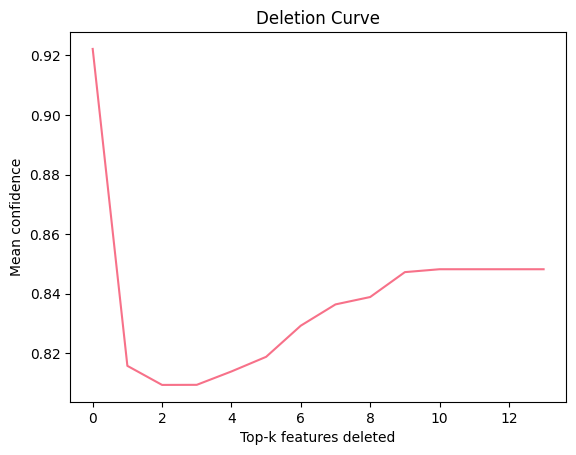

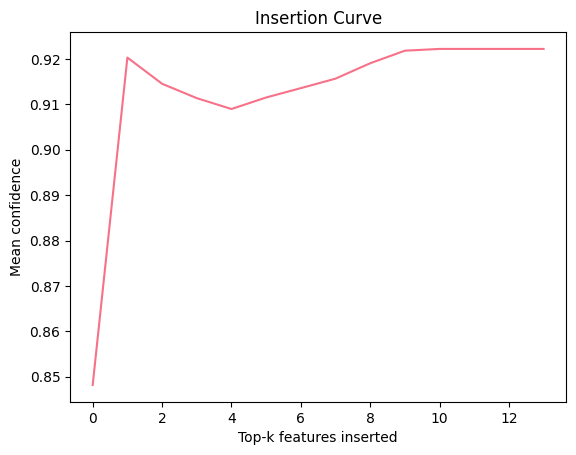

AOPC_deletion: 0.08406902849674225
AUC_insertion: 0.9124168157577515
Comprehensiveness/Sufficiency: {'comp@1': 0.10645217090845108, 'comp@3': 0.11282819449901581, 'comp@5': 0.1034244093298912, 'comp@10': 0.0740002816915512, 'suff@1': -0.0019053491950035096, 'suff@3': -0.010840029120445252, 'suff@5': -0.010700202584266662, 'suff@10': 0.0}
Attribution fidelity: {'spearman_r': 0.4005330780499875, 'n_used': 200}


In [106]:
import json
import matplotlib.pyplot as plt

with open("./results_xai/faithfulness_fidelity_summary.json") as f:
    R = json.load(f)

ks = R["faithfulness_curves"]["ks"]
del_mean = R["faithfulness_curves"]["deletion_curve_mean"]
ins_mean = R["faithfulness_curves"]["insertion_curve_mean"]

# Deletion curve
plt.figure()
plt.plot(ks, del_mean)
plt.title("Deletion Curve")
plt.xlabel("Top-k features deleted")
plt.ylabel("Mean confidence")
plt.show()

# Insertion curve
plt.figure()
plt.plot(ks, ins_mean)
plt.title("Insertion Curve")
plt.xlabel("Top-k features inserted")
plt.ylabel("Mean confidence")
plt.show()

print("AOPC_deletion:", R["faithfulness_curves"]["AOPC_deletion"])
print("AUC_insertion:", R["faithfulness_curves"]["AUC_insertion"])
print("Comprehensiveness/Sufficiency:", R["comp_suff"])
print("Attribution fidelity:", R["attribution_fidelity"])


In [144]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

def attribution_fidelity_r2_rf(X_df, shap_mat, n_samples=200, random_state=42, top_k=20):
    rng = np.random.default_rng(random_state)
    X_np = _ensure_numpy(X_df)
    shap_np = np.asarray(shap_mat)
    n, d = shap_np.shape
    idx = rng.choice(n, size=min(n_samples, n), replace=False)
    Xs, Ss = X_np[idx], shap_np[idx]
    r2s = []
    for x, s in tqdm(zip(Xs, Ss), total=len(Xs)):
        f0 = proba_fn(x.reshape(1,-1))[0]
        deltas = np.zeros(d)
        for j in range(d):
            xm = _mask_features(x,[j],baseline_vec)
            fj = proba_fn(xm.reshape(1,-1))[0]
            deltas[j] = abs(f0-fj)
        feat_idx = np.argsort(-np.abs(s))[:min(top_k, d)]
        X_reg = np.abs(s[feat_idx]).reshape(-1,1)
        y_reg = deltas[feat_idx]
        reg = RandomForestRegressor(n_estimators=100, random_state=42)
        reg.fit(X_reg, y_reg)
        y_hat = reg.predict(X_reg)
        r2s.append(r2_score(y_reg, y_hat))
    return {"R2_fidelity_rf": float(np.mean(r2s)), "n_used": len(r2s)}

print(attribution_fidelity_r2_rf(Xte_df, shap_matrix, n_samples=200, top_k=20))


100%|██████████| 200/200 [00:25<00:00,  7.78it/s]

{'R2_fidelity_rf': 0.7207208901118546, 'n_used': 200}


In [145]:
import json
import numpy as np
import os

def _delta_from_arrays(ks, del_mean, ins_mean, aopc_del=None, auc_ins=None):
    ks = np.asarray(ks)
    del_mean = np.asarray(del_mean, dtype=float)
    ins_mean = np.asarray(ins_mean, dtype=float)

    # --- C1: raw delta (dùng AOPC & AUC sẵn có nếu truyền vào) ---
    if aopc_del is None:
        # AOPC (average drop) ước lượng từ mean curve
        base_conf = del_mean[0]
        drops = base_conf - del_mean
        aopc_del = float(np.mean(drops))
    if auc_ins is None:
        auc_ins = float(np.mean(ins_mean))
    delta_raw = float(auc_ins - aopc_del)

    # --- C2: normalized delta ---
    # Deletion: chuẩn hoá theo drop cực đại
    d0, dK = del_mean[0], del_mean[-1]
    denom_del = (d0 - dK) if abs(d0 - dK) > 1e-9 else 1.0
    del_gain = (d0 - del_mean) / denom_del  # 0→1 tăng theo k
    auc_del_norm = float(np.mean(del_gain))

    # Insertion: chuẩn hoá theo rise cực đại
    i0, iK = ins_mean[0], ins_mean[-1]
    denom_ins = (iK - i0) if abs(iK - i0) > 1e-9 else 1.0
    ins_gain = (ins_mean - i0) / denom_ins  # 0→1 tăng theo k
    auc_ins_norm = float(np.mean(ins_gain))

    delta_norm = float(auc_ins_norm - auc_del_norm)

    return {
        "delta_raw": delta_raw,
        "components_raw": {"AUC_insertion": auc_ins, "AOPC_deletion": aopc_del},
        "delta_norm": delta_norm,
        "components_norm": {"AUC_insertion_norm": auc_ins_norm, "AUC_deletion_norm": auc_del_norm}
    }

# --- Lấy dữ liệu từ biến trong RAM hoặc từ JSON đã lưu ---
if "faithfulness_summary" in globals():
    ks = faithfulness_summary["ks"]
    del_mean = faithfulness_summary["deletion_curve_mean"]
    ins_mean = faithfulness_summary["insertion_curve_mean"]
    aopc_del = faithfulness_summary.get("AOPC_deletion", None)
    auc_ins = faithfulness_summary.get("AUC_insertion", None)
else:
    with open("./results_xai/faithfulness_fidelity_summary.json") as f:
        R = json.load(f)
    ks = R["faithfulness_curves"]["ks"]
    del_mean = R["faithfulness_curves"]["deletion_curve_mean"]
    ins_mean = R["faithfulness_curves"]["insertion_curve_mean"]
    aopc_del = R["faithfulness_curves"].get("AOPC_deletion", None)
    auc_ins = R["faithfulness_curves"].get("AUC_insertion", None)

delta_faith = _delta_from_arrays(ks, del_mean, ins_mean, aopc_del, auc_ins)
print("Δ-faithfulness:", delta_faith)

# --- Ghi bổ sung vào JSON tổng ---
try:
    os.makedirs("./results_xai", exist_ok=True)
    with open("./results_xai/faithfulness_fidelity_summary.json") as f:
        R = json.load(f)
    R["delta_faithfulness"] = delta_faith
    with open("./results_xai/faithfulness_fidelity_summary.json","w") as f:
        json.dump(R, f, indent=2)
    print("Appended Δ-faithfulness to ./results_xai/faithfulness_fidelity_summary.json")
except Exception as e:
    print("Skip saving JSON (not found or not created yet):", e)


Δ-faithfulness: {'delta_raw': 0.8283477872610092, 'components_raw': {'AUC_insertion': 0.9124168157577515, 'AOPC_deletion': 0.08406902849674225}, 'delta_norm': -0.2683678425382874, 'components_norm': {'AUC_insertion_norm': 0.8676881791757765, 'AUC_deletion_norm': 1.1360560217140638}}
Appended Δ-faithfulness to ./results_xai/faithfulness_fidelity_summary.json


In [147]:
# === Sparsity by threshold for ONE sample ===
import numpy as np

# settings
sparsity_threshold = 0.10   # ví dụ 0.1
sample_idx = 7              # chọn 1 index để in minh họa

# lấy shap của 1 mẫu (dùng trị tuyệt đối)
shap_values_sample = np.abs(shap_matrix[sample_idx])

num_significant_features = int(np.sum(shap_values_sample > sparsity_threshold))
print(f"Sparsity: {num_significant_features} features with |SHAP| > {sparsity_threshold}")


Sparsity: 2 features with |SHAP| > 0.1


In [148]:
# === Average sparsity over many samples ===
import numpy as np

sparsity_threshold = 0.10
num_samples_eval = 200
rng = np.random.default_rng(42)

n = shap_matrix.shape[0]
idxs = rng.choice(n, size=min(num_samples_eval, n), replace=False)

sparsity_list = []
for idx in idxs:
    shap_vals = np.abs(shap_matrix[idx])
    count = int(np.sum(shap_vals > sparsity_threshold))
    sparsity_list.append(count)

avg_count = float(np.mean(sparsity_list))
print(f"Average Sparsity over {len(idxs)} samples: {avg_count:.2f} features > {sparsity_threshold}")


Average Sparsity over 200 samples: 2.02 features > 0.1


In [149]:
d = shap_matrix.shape[1]
avg_pct = 100.0 * avg_count / d
print(f"→ i.e., {avg_pct:.2f}% of features on average")


→ i.e., 15.50% of features on average


In [156]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import r2_score

def _score_space_safe(p, use_logit=True, eps=1e-3):
    if not use_logit:
        return p
    p = np.clip(p, eps, 1 - eps)
    return np.log(p / (1 - p))

def _adaptive_sigma(dist_sq, q=0.5, floor=1e-3):
    sig = float(np.sqrt(np.quantile(dist_sq, q) + 1e-12))
    return max(sig, floor)

def _normalize_weights(w, min_w=1e-6):
    w = np.asarray(w, float)
    w = np.nan_to_num(w, nan=0.0, posinf=0.0, neginf=0.0)
    if w.size == 0:
        return w  # rỗng -> trả rỗng, xử lý ở nơi gọi
    w = np.clip(w, min_w, np.inf)
    s = w.sum()
    if s <= 0:
        return np.full_like(w, 1.0 / len(w))
    return w / s


def gen_neighborhood_knn_stable(x, Xtr, k=300, jitter=0.10, rng=None):
    rng = np.random.default_rng() if rng is None else rng
    Xtr_np = Xtr.values if hasattr(Xtr, "values") else np.asarray(Xtr)
    k = int(min(k, len(Xtr_np)))
    # kNN theo Euclid (ổn định)
    nn = NearestNeighbors(n_neighbors=k)
    nn.fit(Xtr_np)
    idx = nn.kneighbors(x.reshape(1,-1), return_distance=False)[0]
    base = Xtr_np[idx]
    # jitter nhẹ theo std
    std = base.std(axis=0, ddof=1); std[std==0] = 1.0
    Z = base + rng.normal(0, jitter * std, size=base.shape)
    Z = np.clip(Z, Xtr_np.min(axis=0), Xtr_np.max(axis=0))
    return Z

def lime_local_r2_stable(
    x, Xtr, proba_fn,
    k=300, jitter=0.10,
    kernel='euclid', sigma_q=0.6,
    surrogate='poly', poly_deg=2, alpha=5.0,
    use_logit=True
):
    x = np.asarray(x)
    Xtr_np = Xtr.values if hasattr(Xtr, "values") else np.asarray(Xtr)

    # 1) Neighborhood
    Z_raw = gen_neighborhood_knn_stable(x, Xtr_np, k=k, jitter=jitter)

    # 2) Scale (chuẩn hoá theo neighborhood để ổn định)
    scaler = StandardScaler().fit(Z_raw)
    Z = scaler.transform(Z_raw)
    x_s = scaler.transform(x.reshape(1,-1))[0]

    # 3) Targets (logit clipped)
    y = _score_space_safe(proba_fn(Z_raw), use_logit=use_logit, eps=1e-3)

    # 4) Distances & weights
    if kernel == 'euclid':
        dist_sq = np.sum((Z - x_s)**2, axis=1)
    else:
        # Mahalanobis trên Z (đã chuẩn hoá)
        cov = np.cov(Z.T) + np.eye(Z.shape[1])*1e-6
        cov_inv = np.linalg.pinv(cov)
        d = Z - x_s
        dist_sq = np.einsum('ij,jk,ik->i', d, cov_inv, d)

    sigma = _adaptive_sigma(dist_sq, q=sigma_q, floor=1e-2)  # sigma floor lớn hơn
    w = np.exp(- dist_sq / (sigma**2))
    w = _normalize_weights(w, min_w=1e-8)

    qcut = np.quantile(w, 0.05) if w.size > 0 else 0.0
    keep = w > qcut
    if keep.sum() < 10:  # tối thiểu 10 điểm để fit
        top = np.argsort(-w)[:min( max(10, w.size), 50 )]
        keep = np.zeros_like(w, dtype=bool)
        keep[top] = True

    Z, y, w = Z[keep], y[keep], w[keep]
    w = _normalize_weights(w, min_w=1e-8)
    if w.size == 0:  # phòng trường hợp cực đoan
        return 0.0

    # 5) Surrogate
    if surrogate == 'poly':
        # Poly bậc 2, không bias; dùng Ridge với alpha>0 để ổn định
        Xfit = PolynomialFeatures(poly_deg, include_bias=False).fit_transform(Z)
        reg = Ridge(alpha=alpha, fit_intercept=True)
        reg.fit(Xfit, y, sample_weight=w)
        y_hat = reg.predict(Xfit)
    elif surrogate == 'ridge':
        reg = Ridge(alpha=alpha, fit_intercept=True)
        reg.fit(Z, y, sample_weight=w)
        y_hat = reg.predict(Z)
    else:
        reg = LinearRegression()
        reg.fit(Z, y, sample_weight=w)
        y_hat = reg.predict(Z)

    # 6) Weighted R^2 (ổn định)
    return float(r2_score(y, y_hat, sample_weight=w))


In [163]:
import random

def sweep_lime_r2_random(n_try=12, seed=42):
    grid = {
        "k": [400, 500],
        "jitter": [0.04, 0.06],
        "sigma_q": [0.5, 0.55, 0.6],
        "surrogate": ["poly", "ridge"],
        "alpha": [5.0, 10.0, 15.0],
    }
    all_combos = list(itertools.product(
        grid["k"], grid["jitter"], grid["sigma_q"], grid["surrogate"], grid["alpha"]
    ))
    random.seed(seed)
    combos = random.sample(all_combos, min(n_try, len(all_combos)))

    results = []
    for idx, (k, jitter, sigma_q, surrogate, alpha) in enumerate(combos, 1):
        mean_r2, _, _ = lime_r2_mean_stable(
            Xte_df, Xtr_df, proba_fn,
            n_eval=50,   # ít mẫu hơn để nhanh
            k=k,
            jitter=jitter,
            kernel='euclid',
            sigma_q=sigma_q,
            surrogate=surrogate,
            poly_deg=2,
            alpha=alpha,
            use_logit=True
        )
        results.append(mean_r2)
        print(f"[{idx}/{len(combos)}] {k,jitter,sigma_q,surrogate,alpha} -> R²={mean_r2:.3f}")

    print("\nAverage R² ≈", np.mean(results))
    return results
sweep_lime_r2_random()

[1/12] (400, 0.04, 0.6, 'poly', 15.0) -> R²=0.691
[2/12] (400, 0.04, 0.5, 'ridge', 5.0) -> R²=0.412
[3/12] (400, 0.06, 0.6, 'ridge', 15.0) -> R²=0.585
[4/12] (400, 0.06, 0.6, 'poly', 10.0) -> R²=0.595
[5/12] (400, 0.06, 0.55, 'ridge', 10.0) -> R²=0.587
[6/12] (400, 0.04, 0.6, 'ridge', 15.0) -> R²=0.525
[7/12] (400, 0.04, 0.6, 'poly', 10.0) -> R²=0.575
[8/12] (400, 0.04, 0.55, 'ridge', 15.0) -> R²=0.605
[9/12] (500, 0.06, 0.5, 'poly', 5.0) -> R²=0.447
[10/12] (400, 0.04, 0.5, 'poly', 15.0) -> R²=0.571
[11/12] (400, 0.04, 0.5, 'poly', 10.0) -> R²=0.534
[12/12] (400, 0.04, 0.5, 'ridge', 15.0) -> R²=0.485

Average R² ≈ 0.5508333895471008


[0.691051176941126,
 0.41158666471159094,
 0.5847468619750132,
 0.5948657519882306,
 0.586627123591256,
 0.524886228562823,
 0.5746725514818364,
 0.604680192924346,
 0.446989815228514,
 0.5708533599260478,
 0.5344366160197045,
 0.4846043312147222]

In [157]:
def lime_r2_mean_stable(Xte, Xtr, proba_fn, n_eval=200, random_state=42, **kwargs):
    rng = np.random.default_rng(random_state)
    X_np = Xte.values if hasattr(Xte,"values") else np.asarray(Xte)
    n = X_np.shape[0]
    idxs = rng.choice(n, size=min(n_eval, n), replace=False)
    vals = []
    for i in idxs:
        vals.append(lime_local_r2_stable(X_np[i], Xtr, proba_fn, **kwargs))
    return float(np.mean(vals)), float(np.std(vals)), len(vals)

mean_r2, std_r2, n_used = lime_r2_mean_stable(
    Xte_df, Xtr_df, proba_fn,
    n_eval=200,
    k=300,
    jitter=0.06,          # nhiễu nhẹ hơn
    kernel='euclid',      # bắt đầu với euclid cho ổn định
    sigma_q=0.6,
    surrogate='poly',
    poly_deg=2,
    alpha=8.0,            # ridge mạnh hơn để ổn định
    use_logit=True
)
print({"LIME_R2_mean_stable": mean_r2, "std": std_r2, "n_eval": n_used})


{'LIME_R2_mean_stable': 0.5903103770419174, 'std': 0.476799893782064, 'n_eval': 200}
